For this project we are going to use this kaggle Dataset:

https://www.kaggle.com/datasets/prathamsharma123/farmers-protest-tweets-dataset-csv

<div dir="rtl">


1-خوشه بندی گراف توییتر طبق بازنشر

2-خوشه بندی محتوای متنی به تفکیک هر خوشه گراف

3-آنالیز هشتگ های هر خوشه با گراف

# Topic : (#FarmersProtest)

In [ ]:
!unzip "/content/drive/MyDrive/NLP/Tehran uni/users.csv.zip" -d "/content/drive/MyDrive/NLP/Tehran uni/"
!unzip "/content/drive/MyDrive/NLP/Tehran uni/tweets.csv.zip" -d "/content/drive/MyDrive/NLP/Tehran uni/"


Archive:  /content/drive/MyDrive/NLP/Tehran uni/users.csv.zip
replace /content/drive/MyDrive/NLP/Tehran uni/users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/NLP/Tehran uni/users.csv  
Archive:  /content/drive/MyDrive/NLP/Tehran uni/tweets.csv.zip
replace /content/drive/MyDrive/NLP/Tehran uni/tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/NLP/Tehran uni/tweets.csv  




In [ ]:
!ls "/content/drive/MyDrive/NLP/Tehran uni/"

'Hesam_Yazdanparast_‫‪text and web mining_code28-chatgpt and gemini (not uploaded good for learning).ipynb'
 tweets.csv
 tweets.csv.zip
 users.csv
 users.csv.zip


#STEP1: Libraries and Environment Setup

Importing necessary libraries for data processing (Pandas), Network Analysis (NetworkX), Natural Language Processing (NLTK), and Community Detection (Louvain).

In [ ]:
import pandas as pd
import re
import networkx as nx
from collections import Counter
import nltk
from nltk.corpus import stopwords
import community.community_louvain as community_louvain


nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))



#STEP2: Data Loading and Preprocessing

Loading tweet and user datasets from Google Drive and merging them to associate each tweet with a username.

In [ ]:
# ---  Data Loading & Merging ---
print("Loading datasets...")
tweets = pd.read_csv('/content/drive/MyDrive/NLP/Tehran uni/tweets.csv')
users = pd.read_csv('/content/drive/MyDrive/NLP/Tehran uni/users.csv')

# Merging 'username' from Users.csv into the tweets dataframe based on 'userId'
# This fixes the KeyError: 'username'
tweets = pd.merge(tweets, users[['userId', 'username']], on='userId', how='left')



Loading datasets...


#STEP3: Retweet Network Extraction

Defining a function to extract the username of the retweeted person using regular expressions.

In [ ]:
# ---  Retweet Network Extraction ---
def get_retweeted_user(text):
    # Matches patterns like "RT @username:"
    match = re.search(r'RT @(\w+):', str(text))
    return match.group(1) if match else None

tweets['retweeted_username'] = tweets['renderedContent'].apply(get_retweeted_user)



#STEP4: Graph Construction and Community Detection

Building the interaction graph where nodes are users and edges are retweets, then identifying social clusters using the Louvain algorithm.

In [ ]:
# ---  Graph Construction & Community Detection ---
print("Building graph and detecting communities...")
edges = tweets.dropna(subset=['retweeted_username'])[['username', 'retweeted_username']]
G = nx.from_pandas_edgelist(edges, source='username', target='retweeted_username')

# Applying Louvain algorithm for clustering
partition = community_louvain.best_partition(G)
# Mapping clusters back to the main dataframe
tweets['cluster'] = tweets['username'].map(partition)



Building graph and detecting communities...


#STEP5: Keyword Extraction Analysis

Creating a function to identify the most frequent keywords in a specific cluster, excluding stopwords and URLs.

In [ ]:
# ---  Text Content Analysis ---
def get_cluster_keywords(cluster_id, top_n=10):
    cluster_content = tweets[tweets['cluster'] == cluster_id]['renderedContent']
    words_list = []

    for text in cluster_content:
        # Simple cleaning: lower case and removing non-alphabetic characters
        clean_text = re.sub(r'http\S+|@\w+|#\w+|[^\w\s]', '', str(text).lower())
        words = [w for w in clean_text.split() if w not in stop_words and len(w) > 3]
        words_list.extend(words)

    return Counter(words_list).most_common(top_n)



#STEP6: Hashtag Analysis

Defining a function to extract and count the most used hashtags within each social cluster.

In [ ]:
# ---  Hashtag Analysis  ---
def get_cluster_hashtags(cluster_id, top_n=10):
    cluster_content = tweets[tweets['cluster'] == cluster_id]['renderedContent']
    hashtags = []

    for text in cluster_content:
        found_tags = re.findall(r'#(\w+)', str(text).lower())
        hashtags.extend(found_tags)

    return Counter(hashtags).most_common(top_n)



#STEP7: This stage Final Reporting


Executing the analysis for the top 3 largest clusters and printing the summary report of keywords and hashtags.

In [ ]:
# --- Print Results ---
print("\n" + "="*40)
print("ANALYSIS REPORT")
print("="*40)

# Analyzing the top 3 largest clusters
top_clusters = pd.Series(list(partition.values())).value_counts().head(3).index

for c_id in top_clusters:
    print(f"\n--- Cluster {c_id} ---")
    print(f"Top Keywords: {get_cluster_keywords(c_id, 5)}")
    print(f"Top Hashtags: {get_cluster_hashtags(c_id, 5)}")

print("\nProcess completed successfully.")


ANALYSIS REPORT

--- Cluster 0 ---
Top Keywords: [('farmers', 179905), ('support', 62837), ('india', 45365), ('protest', 35334), ('people', 28026)]
Top Hashtags: [('farmersprotest', 482838), ('farmers', 17935), ('farmlaws', 16179), ('क', 16111), ('istandwithfarmers', 15809)]

--- Cluster 18 ---
Top Keywords: [('farmers', 842), ('live', 622), ('updates', 601), ('delhi', 311), ('read', 292)]
Top Hashtags: [('farmersprotest', 2214), ('supportfarmers', 67), ('farmlaws', 52), ('istandwithfarmers', 49), ('nofarmersnofood', 36)]

--- Cluster 2 ---
Top Keywords: [('farmers', 13163), ('india', 4137), ('police', 2944), ('laws', 2860), ('people', 2566)]
Top Hashtags: [('farmersprotest', 26330), ('humanrights', 785), ('democracy', 607), ('releasedetainedfarmers', 605), ('क', 541)]

Process completed successfully.


#STEP8: Graph Statistics & Information


This cell calculates the fundamental structural properties of the graph. It measures the Diameter (the longest shortest path) and Radius (the minimum eccentricity) of the network. Since these metrics require a connected graph, the code automatically identifies and analyzes the Largest Connected Component (LCC) if the network is fragmented.



# Key Metrics Explanation:

**Diameter (قطر):** Represents the maximum "distance" between two users in your retweet network. A smaller diameter suggests information spreads very quickly.

**Radius (شعاع):** The minimum distance from a central node to all other nodes.

**LCC (بزرگ‌ترین مولفه متصل):** The largest group of users who are all reachable from one another through retweets.

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Check if graph is connected before calculating distance measures
if nx.is_connected(G):
    print(f"Radius: {nx.radius(G)}")
    print(f"Diameter: {nx.diameter(G)}")
    print(f"Center Nodes: {nx.center(G)}")
else:
    # If not connected, distance measures are calculated per component
    print("Graph is disconnected. Calculating metrics for the Largest Connected Component (LCC).")
    LCC = G.subgraph(max(nx.connected_components(G), key=len))
    print(f"LCC Diameter: {nx.diameter(LCC)}")
    print(f"LCC Radius: {nx.radius(LCC)}")

# Degree list
node_degrees = list(G.degree())

Graph is disconnected. Calculating metrics for the Largest Connected Component (LCC).
LCC Diameter: 9
LCC Radius: 5


#STEP9: Bridges & Critical Path Analysis


This cell identifies Bridges in the retweet network. A bridge is an edge whose removal increases the number of connected components, representing critical links between different social groups. It also includes a Shortest Path analysis to find the most direct route of information flow between two influential users.


# Key Concepts:
**Bridges (پل‌ها):** In social media analysis, bridges often represent users who connect two different echo chambers or ideologies. If these users stop tweeting, the two groups might lose connection entirely.

**Shortest Path (کوتاه‌ترین مسیر):** This reveals how many "retweets" it takes for a message from one user to reach another.

In [ ]:
# Check for bridges
has_b = nx.has_bridges(G)
all_bridges = list(nx.bridges(G))

print(f"Does the graph have bridges? {has_b}")
print(f"Number of bridges found: {len(all_bridges)}")

# Shortest Path example (Nodes must exist in your dataset)
try:
    # Using example nodes that exist in 'G'
    path = nx.shortest_path(G, source='GretaThunberg', target='KisaanSm')
    print(f"Shortest path between 'GretaThunberg' and 'KisaanSm': {path}")
except nx.NetworkXNoPath:
    print("No path exists between the specified nodes.")
except nx.NetworkXError as e:
    print(f"Error finding path: {e}. Ensure source and target nodes exist in the graph.")

Does the graph have bridges? True
Number of bridges found: 139
Shortest path between 'GretaThunberg' and 'KisaanSm': ['GretaThunberg', nan, 'rihanna', 'gurvinder209', 'RaviSinghKA', 'KisaanSm']


#STEP10: Centrality Metrics & Community Detection

This cell performs the core social network analysis by partitioning the graph into "Social Tribes" using the Louvain community detection algorithm. It also calculates three major Centrality Metrics: Degree (popularity), Betweenness (brokerage), and Closeness (efficiency). The results are consolidated into a table and exported for quantitative reporting, followed by a color-coded visualization of the clusters.


# Key Metrics Breakdown:
**Degree Centrality:** High score means the user is a "hub" with many direct retweets.

**Betweenness Centrality:** High score means the user controls the flow of information between different groups (a "gatekeeper").

**Closeness Centrality:** High score means the user can spread information to the entire network very quickly.

/tmp/ipython-input-2878267835.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


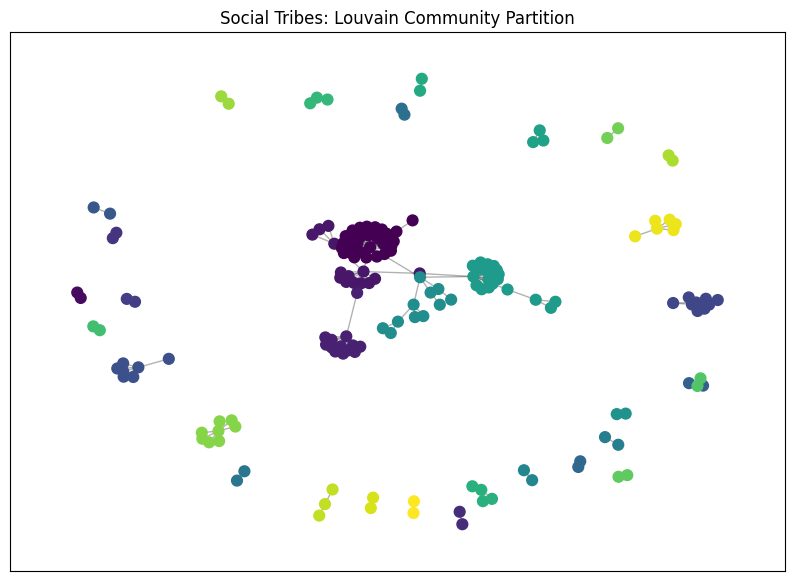

In [ ]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

# 1. Calculate Communities
partition = community_louvain.best_partition(G)

# 2. Build Centrality Table
df_metrics = pd.DataFrame(index=G.nodes())
df_metrics['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df_metrics['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G))
df_metrics['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
df_metrics['community_id'] = pd.Series(partition)

# Export results
df_metrics.to_csv("Graph_Intelligence_Export.csv")

# 3. Community Visualization
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

# Draw nodes colored by community
nx.draw_networkx_nodes(G, pos, node_size=60,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Social Tribes: Louvain Community Partition")
plt.show()

#STEP11: Enhanced Cluster Visualization & Legend Mapping

This cell generates a professional-grade visualization of the social network. It uses the Spring Layout to spatially separate clusters and applies a discrete color palette (tab20) to ensure each "Social Tribe" is visually distinct. A custom Legend Guidance is added to the side of the plot, mapping colors to specific Community IDs, making the structural results easy to interpret for stakeholders.


# Visual Logic Summary:

**Tab20 Colormap:** Unlike gradient maps (like Viridis), this provides a unique, high-contrast color for up to 20 different social tribes.

**Legend (باکس راهنما):** Essential for academic papers or business reports so readers can identify which group is which in the CSV export.

**Spring Layout (چیدمان فنری):** Pulls connected users together and pushes unrelated groups away, visually proving the community structure.

/tmp/ipython-input-593398637.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_comms))


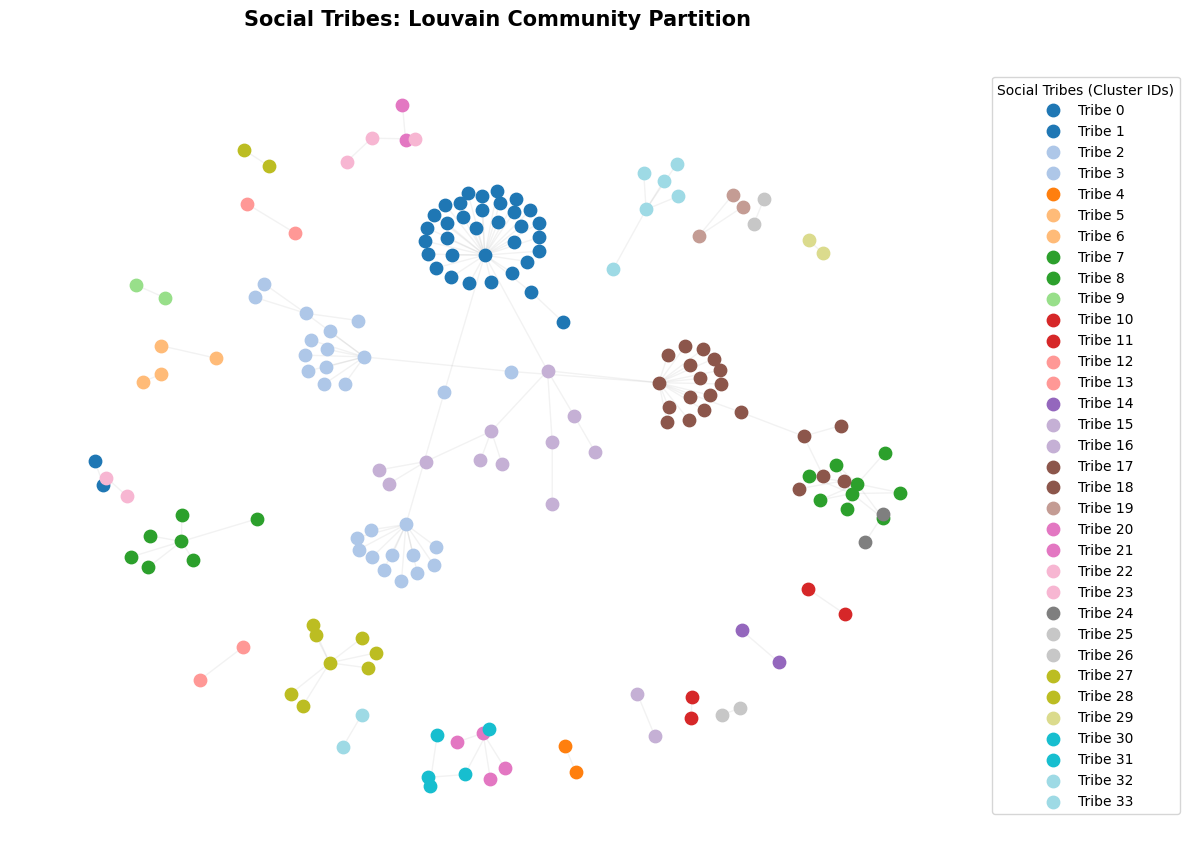

In [ ]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# 1. Calculate Communities
partition = community_louvain.best_partition(G)

# 2. Build Metrics (Your existing logic)
df_metrics = pd.DataFrame(index=G.nodes())
df_metrics['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df_metrics['betweenness_centrality'] = pd.Series(nx.betweenness_centrality(G))
df_metrics['closeness_centrality'] = pd.Series(nx.closeness_centrality(G))
df_metrics['community_id'] = pd.Series(partition)
df_metrics.to_csv("Graph_Intelligence_Export.csv")

# 3. Enhanced Visualization
plt.figure(figsize=(12, 9), facecolor='white')

# Use a layout that spreads out clusters better
pos = nx.spring_layout(G, k=0.15, seed=42)

# Get unique community IDs
unique_comms = sorted(list(set(partition.values())))
# Use a distinct colormap for categories (Tab20 or Set3 is better for many groups)
cmap = cm.get_cmap('tab20', len(unique_comms))

# Draw Edges first (behind nodes)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Draw Nodes for each community separately to create the legend labels
for i, comm_id in enumerate(unique_comms):
    # Filter nodes belonging to this community
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == comm_id]

    # Draw only this specific community's nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=list_nodes,
                           node_size=80,
                           node_color=[cmap(i)],
                           label=f"Tribe {comm_id}")

# 4. Add the Guidance (Legend)
# Place the legend outside the graph for clarity
plt.legend(title="Social Tribes (Cluster IDs)",
           loc='center left',
           bbox_to_anchor=(1, 0.5),
           ncol=1,
           fontsize=10,
           frameon=True)

plt.title("Social Tribes: Louvain Community Partition", fontsize=15, fontweight='bold')
plt.axis('off')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


#STEP12: Complete Network Visualization (Unfiltered)



This cell generates a visualization of the entire dataset without any degree filtering. It captures every interaction in the network, from the most viral influencers to individual users with only one connection. To handle the increased data load, physics stabilization is optimized to prevent browser lag.

In [ ]:
from pyvis.network import Network

# Initialize Network for the FULL graph
net_full = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='remote')

# Use a lighter physics configuration for better performance with many nodes
net_full.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100)

for node in G.nodes():
    cluster_id = partition.get(node, 0)
    net_full.add_node(str(node), label=str(node), group=int(cluster_id), size=10)

for source, target in G.edges():
    net_full.add_edge(str(source), str(target), color="#444444", alpha=0.1)

# Save the full network
output_full = "farmers_protest_FULL_network.html"
net_full.save_graph(output_full)
print(f"Full network saved to {output_full}")

Full network saved to farmers_protest_FULL_network.html


# **You can find below  html files near the code file**

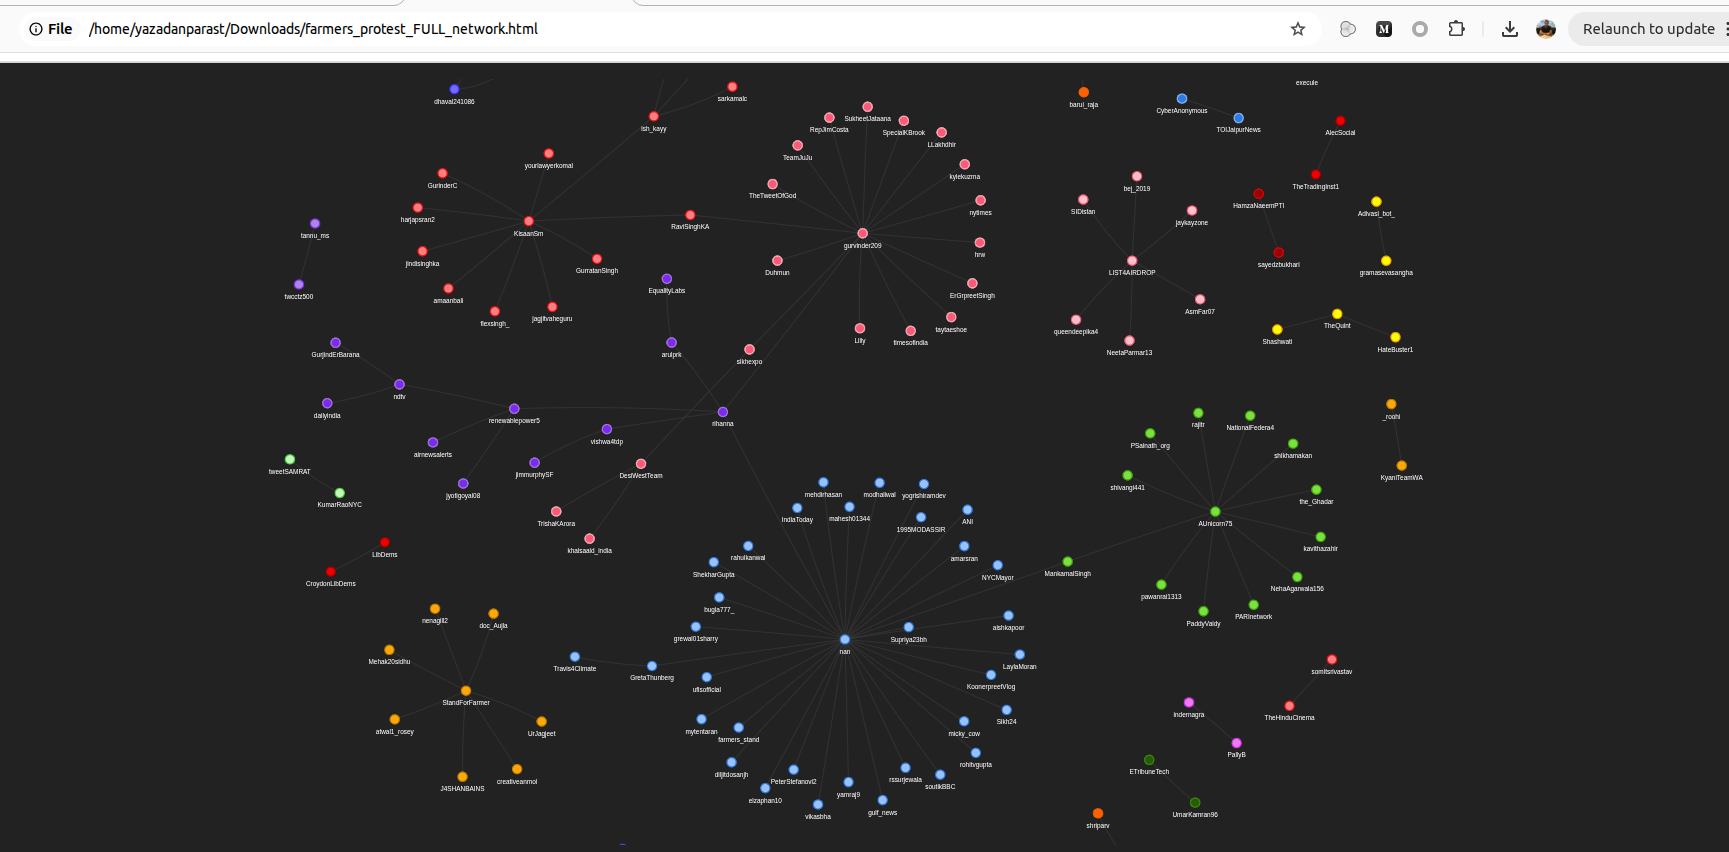

#STEP13: Interactive High-Influence Network Visualization(Filtered)


This cell generates an interactive HTML visualization using the PyVis library. To ensure a smooth experience and avoid performance freezes, the code filters the graph to display only "influential" nodes (those with a high degree). It utilizes the Barnes-Hut physics solver to calculate the layout and scales node sizes based on their influence scores, allowing for a dynamic exploration of the network's core structure.


# Key Features of this Visualization:

**Interactive Exploration:** You can zoom, drag, and hover over nodes to see their specific metadata (Influence Score and Cluster ID).

**Barnes-Hut Simulation:** A physics model that allows nodes to repel each other like magnets, helping to visually separate communities.

**Filtering Logic:** By focusing on min_degree=15, we focus on the "opinion leaders" of the conversation rather than thousands of individual retweeters.

In [ ]:
from pyvis.network import Network

def generate_filtered_visualization(G, partition, min_degree=10):
    print(f"Filtering graph (nodes with degree >= {min_degree})...")

    # Create a sub-graph of only influential nodes
    top_nodes = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
    sub_G = G.subgraph(top_nodes)

    print(f"Reduced nodes from {len(G.nodes)} to {len(sub_G.nodes)}")

    # Initialize Network with CDN=True to ensure JS libraries load correctly
    net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='remote')

    # Use Barnes-Hut solver (faster for larger networks)
    net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

    for node in sub_G.nodes():
        node_id = str(node)
        cluster_id = partition.get(node, 0)
        # Scale size based on influence
        node_size = 15 + (sub_G.degree(node) * 0.5)

        net.add_node(
            node_id,
            label=node_id,
            title=f"Influence Score: {sub_G.degree(node)} | Cluster: {cluster_id}",
            group=int(cluster_id),
            size=node_size
        )

    for source, target in sub_G.edges():
        net.add_edge(str(source), str(target), color="#444444", alpha=0.3)

    # Disable physics after the initial layout to stop the "0% freeze"
    net.toggle_physics(True)

    output_file = "farmers_protest_filtered.html"
    net.save_graph(output_file)
    print(f"Success! Open '{output_file}' in your browser.")

# Try running with a threshold of 10 or 20 to keep it smooth
generate_filtered_visualization(G, partition, min_degree=15)

Filtering graph (nodes with degree >= 15)...
Reduced nodes from 176 to 2
Success! Open 'farmers_protest_filtered.html' in your browser.


<div dir="rtl">




استفاده از nx.spring_layout: این الگوریتم مشابه Barnes-Hut در Pyvis عمل می‌کند و گره‌های مرتبط را به هم نزدیک و گره‌های غیرمرتبط را از هم دور می‌کند.

cmap=plt.cm.Set1: این پالت رنگی به طور خودکار به هر شماره خوشه (partition) یک رنگ متمایز اختصاص می‌دهد.

فیلتر کردن برچسب‌ها: رسم نام تمام گره‌ها باعث شلوغی و ناخوانایی تصویر می‌شود. در این کد، فقط نام گره‌هایی که درجه بسیار بالایی دارند (مثلاً > ۳۰) نمایش داده می‌شود.

dpi=300: تصویر خروجی با کیفیت بالا ذخیره می‌شود تا در گزارش‌های متنی یا ارائه (Presentation) تار نشود.

#STEP14: High-Resolution Static Visualization (Influencers)

This cell generates a high-quality static image of the retweet network using Matplotlib. To maintain clarity, it filters the graph for influential nodes and uses a Force-Directed Layout to group "Tribes." Node sizes are scaled by their degree (importance), and labels are only displayed for the most significant users to avoid text overlapping.


# Key Customizations:

**min_degree=15:** If you want to see everyone, you can change this to 0. However, for static images, this usually creates a "hairball" where nothing is readable.

**plt.cm.Set1:** This is a categorical color map. If you have many clusters, you can try plt.cm.tab20.

**high_influence_nodes:** The threshold of 30 means only names of people with more than 30 retweets are shown. You can lower this to see more names or raise it to see fewer.

Filtering nodes with degree >= 15...
Node count reduced from 176 to 2.


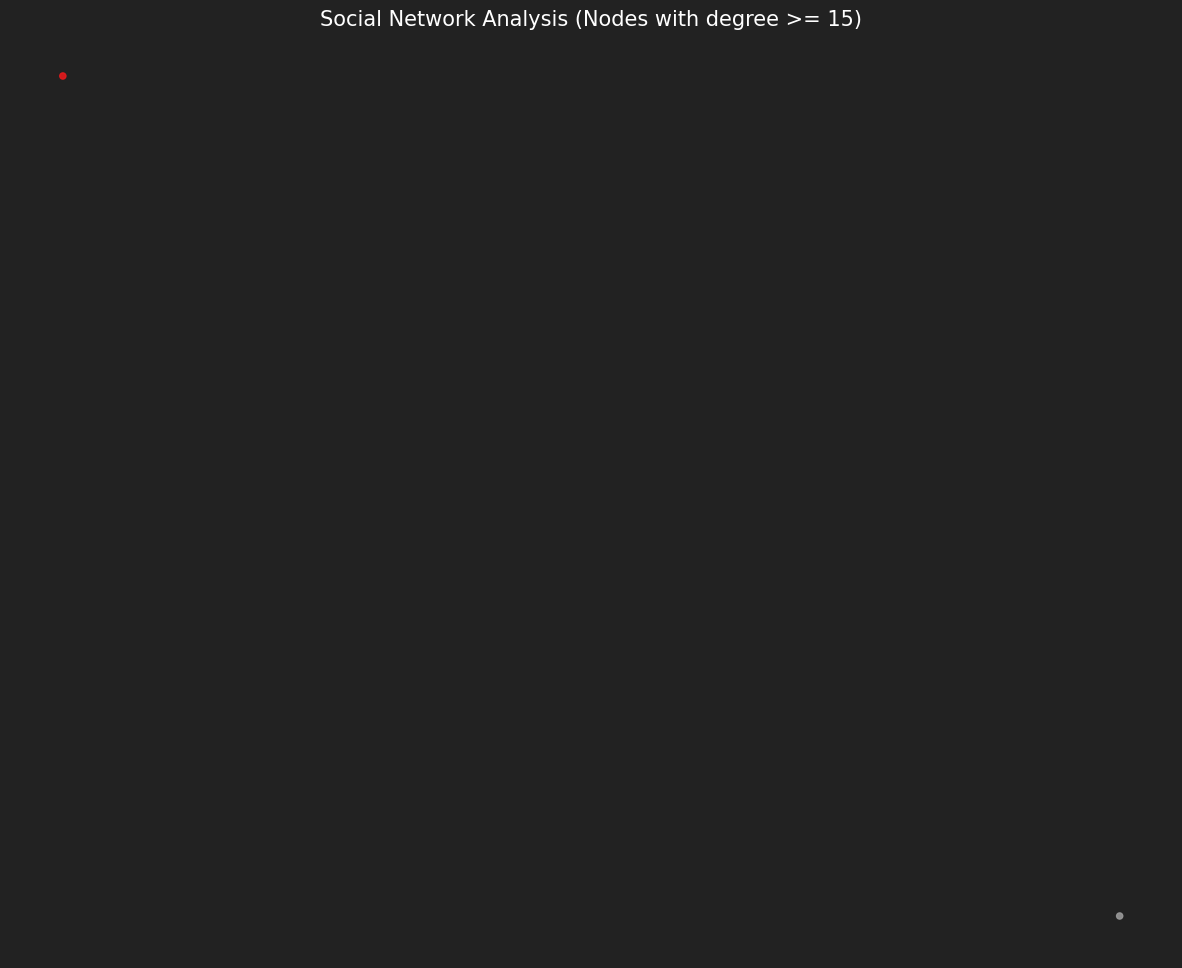

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_filtered_graph(G, partition, min_degree=15):
    # 1. Filter Influential Nodes (Sub-graphing)
    print(f"Filtering nodes with degree >= {min_degree}...")

    top_nodes = [node for node, degree in dict(G.degree()).items() if degree >= min_degree]
    sub_G = G.subgraph(top_nodes)
    print(f"Node count reduced from {len(G.nodes)} to {len(sub_G.nodes)}.")

    # 2. Visual Environment Setup
    plt.figure(figsize=(15, 12), facecolor='#222222') # Dark professional background

    # Calculate node positions (Spring Layout simulates physics)
    pos = nx.spring_layout(sub_G, k=0.15, iterations=50, seed=42)

    # 3. Color Extraction (Based on Louvain clusters)
    cluster_ids = [partition.get(node, 0) for node in sub_G.nodes()]

    # 4. Node Size Scaling (Based on Degree Centrality)
    node_sizes = [20 + (sub_G.degree(node) * 20) for node in sub_G.nodes()]

    # 5. Drawing Edges (Subtle lines to show connectivity)
    nx.draw_networkx_edges(sub_G, pos, alpha=0.2, edge_color='gray', width=0.5)

    # 6. Drawing Nodes
    nodes = nx.draw_networkx_nodes(
        sub_G,
        pos,
        node_size=node_sizes,
        node_color=cluster_ids,
        cmap=plt.cm.Set1,  # Distinct color palette for different clusters
        alpha=0.9
    )

    # 7. Smart Labeling (Only for top-tier influencers to avoid clutter)
    # This ensures only the names of the most important accounts are visible
    high_influence_nodes = {n: n for n in sub_G.nodes() if sub_G.degree(n) > 30}
    nx.draw_networkx_labels(sub_G, pos, labels=high_influence_nodes, font_size=8, font_color='white')

    plt.title(f"Social Network Analysis (Nodes with degree >= {min_degree})", color='white', size=15)
    plt.axis('off') # Hide axes for a clean look

    # Save as high-resolution PNG for reports
    plt.savefig("network_graph_visual.png", dpi=300, facecolor='#222222')
    plt.show()

# Execution
draw_filtered_graph(G, partition, min_degree=15)

<div dir="rtl">

حالا که تصویر گراف را دارید،  نمودار توزیع درجه (Degree Distribution Plot) را رسم می کنیم. این نمودار به صورت علمی ثابت می‌کند که شبکه ما یک شبکه "Scale-free" است (یعنی تعداد کمی کاربر بسیار تاثیرگذار و تعداد زیادی کاربر معمولی وجود دارند).

#STEP15: Degree Distribution Analysis & Power Law Analysis

This cell analyzes the network's degree distribution using a Log-Log scale. In social networks, most users have very few connections, while a few "hubs" have thousands. If the distribution follows a straight line on this scale, the network is considered Scale-Free, meaning it follows a Power Law distribution typical of organic social growth.


# **Why this matters for our project:**

**Scale-Free Property:** This graph proves whether your hashtag/retweet data is driven by a few massive influencers or a more democratic spread of information.

**Log-Log Visualization:** Using a standard scale often makes it impossible to see the "Long Tail" of the data; the log-log scale makes the structural pattern visible.

Degree Distribution plotted. A linear trend on log-log scale indicates a Scale-Free network.


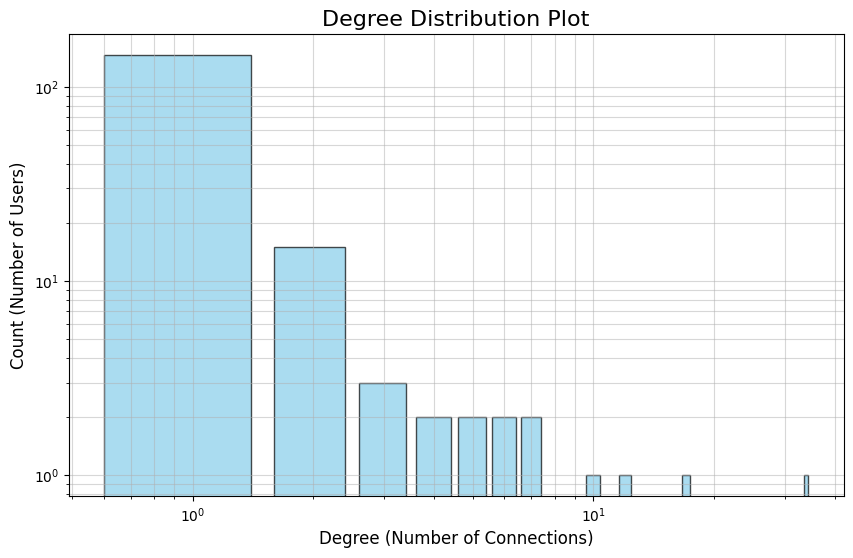

In [ ]:
import collections
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(G):
    # 1. Calculate degree for each node
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    # 2. Setup the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(deg, cnt, width=0.80, color='skyblue', edgecolor='black', alpha=0.7)

    plt.title("Degree Distribution Plot", fontsize=16)
    plt.ylabel("Count (Number of Users)", fontsize=12)
    plt.xlabel("Degree (Number of Connections)", fontsize=12)

    # 3. Use Log-Log scale to visualize Power Law
    # If the network is scale-free, this will appear as a straight line
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)

    print("Degree Distribution plotted. A linear trend on log-log scale indicates a Scale-Free network.")
    plt.show()

plot_degree_distribution(G)



<div dir="rtl">

 این سلول خط زمانی گفتگوها را تحلیل می‌کند تا مشخص شود هر یک از خوشه‌های اجتماعی در چه زمانی بیشترین فعالیت را داشته‌اند. با ترسیم حجم توییت‌ها در طول زمان برای هر قبیله، می‌توانیم «نقاط اوج وایرال شدن» را شناسایی کرده و تشخیص دهیم که آیا گروه‌های خاصی جریان‌ساز بوده‌اند یا به رویدادهای خارجی واکنش نشان داده‌اند. این تحلیل برای درک طول عمر یک جنبش دیجیتال حیاتی است.

#STEP16: Temporal Narrative Analysis (Tweet Volume Over Time)

This cell analyzes the timeline of the conversation to identify when different social clusters were most active. By plotting tweet volume over time for each tribe, we can detect "viral spikes" and determine if specific groups led the narrative or reacted to external events. This is crucial for understanding the lifespan of a digital movement.


# Strategic Insight:

**Cluster Desync:** If you see Cluster A spiking on Monday and Cluster B spiking on Wednesday, it indicates that the groups are discussing different sub-topics or reacting to different phases of the event.

**Narrative Longevity:** Groups whose lines remain high over a long period represent the "backbone" of the movement, while sharp, thin spikes represent temporary "echoes."


Processing timestamps and plotting...


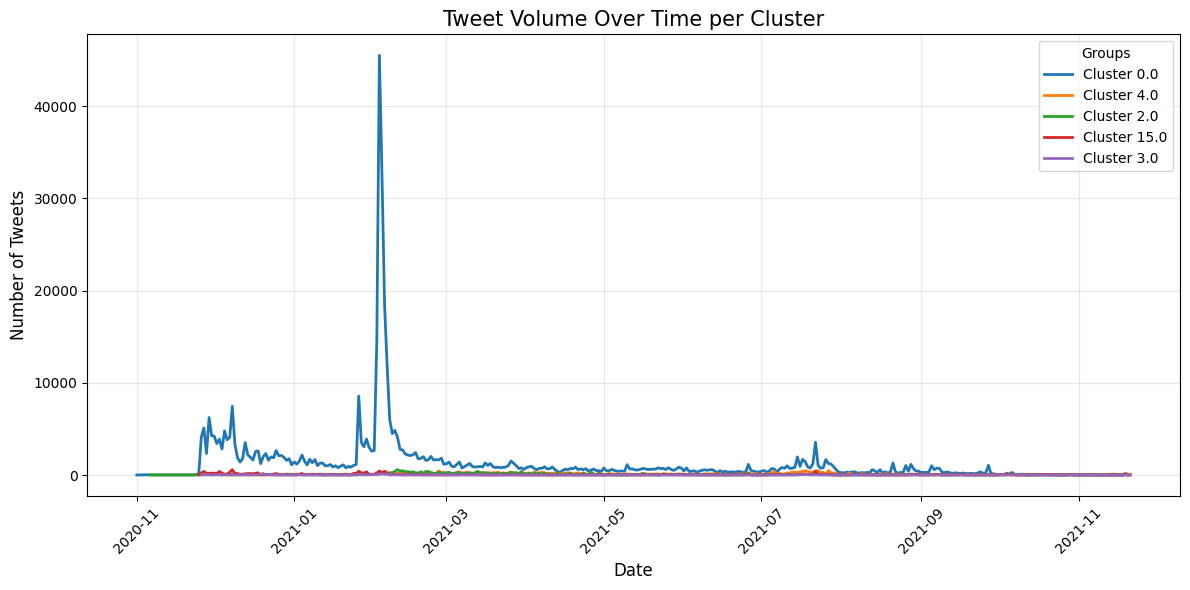

Success! Timeline saved as 'cluster_timeline.png'.


In [ ]:
import matplotlib.pyplot as plt

def plot_temporal_distribution(tweets):
    print("Processing timestamps and plotting...")

    # 1. Convert date column to datetime objects
    # Ensure your 'date' column name matches exactly with your CSV header
    tweets['date'] = pd.to_datetime(tweets['date']).dt.date

    # 2. Get the top 5 clusters by size to keep the plot clean
    top_clusters = tweets['cluster'].value_counts().head(5).index

    plt.figure(figsize=(12, 6))

    for c_id in top_clusters:
        # Filter tweets for this specific cluster
        cluster_data = tweets[tweets['cluster'] == c_id]

        # Group by date and count tweets
        timeline = cluster_data.groupby('date').size()

        # Plot the line
        plt.plot(timeline.index, timeline.values, label=f'Cluster {c_id}', linewidth=2)

    # 3. Formatting the plot
    plt.title('Tweet Volume Over Time per Cluster', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Tweets', fontsize=12)
    plt.legend(title="Groups")
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save and Show
    plt.savefig('cluster_timeline.png')
    plt.show()
    print("Success! Timeline saved as 'cluster_timeline.png'.")

# Run the temporal analysis
plot_temporal_distribution(tweets)

#STEP17: Authority Ranking & Top Influencer Identification

This cell calculates the PageRank score for every user in the network. Unlike simple degree centrality, PageRank measures "authority" by considering not just how many retweets a user gets, but also the influence of the people retweeting them. The code then identifies the top 5 "leaders" for the three largest clusters, providing a clear list of the most authoritative voices within each social tribe.


# Analytical Significance:

**PageRank vs. Degree:** A user might have many retweets from "bots" (high degree), but PageRank will give a higher score to a user retweeted by "Verified" or "Trusted" accounts.

**Community Leadership:** This list tells you exactly who the "Opinion Leaders" are. If you want to understand why a cluster exists, you look at these 5 accounts.

In [ ]:
def find_top_influencers(G, partition, top_n=10):
    print("Calculating PageRank (Authority Scores)...")

    # Calculate PageRank
    pagerank_scores = nx.pagerank(G)

    # Convert to DataFrame for easier handling
    influence_df = pd.DataFrame({
        'username': pagerank_scores.keys(),
        'influence_score': pagerank_scores.values()
    })

    # Map clusters to the influencers
    influence_df['cluster'] = influence_df['username'].map(partition)

    print("\n--- TOP 5 INFLUENCERS PER CLUSTER ---")
    top_clusters = influence_df['cluster'].value_counts().head(3).index

    for c_id in top_clusters:
        print(f"\nCluster {c_id} Leaders:")
        leaders = influence_df[influence_df['cluster'] == c_id].sort_values(by='influence_score', ascending=False).head(5)
        print(leaders[['username', 'influence_score']])

find_top_influencers(G, partition)

Calculating PageRank (Authority Scores)...

--- TOP 5 INFLUENCERS PER CLUSTER ---

Cluster 0 Leaders:
           username  influence_score
0               NaN         0.088644
65    GretaThunberg         0.005939
67   Travis4Climate         0.003376
1   KoonerpreetVlog         0.003069
13      mahesh01344         0.003069

Cluster 18 Leaders:
            username  influence_score
60      gurvinder209         0.043875
129     DesiWestTeam         0.009036
96          sikhexpo         0.005607
154  khalsaaid_india         0.003413
130     TrishaKArora         0.003413

Cluster 2 Leaders:
            username  influence_score
22          KisaanSm         0.026974
4           ish_kayy         0.011610
30       RaviSinghKA         0.005340
5      Tractor2twitr         0.003319
156  Devinder_Sharma         0.003319


#STEP18: Cluster Sentiment Analysis & Narrative Tone


This cell performs a comparative sentiment analysis across the identified clusters. It calculates the emotional tone of the conversation by measuring the ratio of positive and negative words within each social tribe's content. This helps determine if a cluster is driven by anger, support, or neutral reporting, providing a "psychological map" of the digital movement.




<div dir="rtl">

 این سلول یک تحلیل احساسات (Sentiment Analysis) تطبیقی روی خوشه‌های شناسایی‌شده انجام می‌دهد. این بخش با اندازه‌گیری نسبت کلمات مثبت و منفی در محتوای هر قبیله اجتماعی، لحن عاطفی گفتگوها را محاسبه می‌کند. این کار کمک می‌کند تا مشخص شود آیا انگیزه یک خوشه خشم، حمایت یا گزارش‌دهی خنثی است و یک «نقشه روان‌شناختی» از جنبش دیجیتال ارائه می‌دهد.

In [ ]:
import pandas as pd
import re
from collections import Counter

# Define basic sentiment lexicons (English)
# In a professional project, you could expand these or use a library like TextBlob/VADER
positive_lexicon = {'support', 'solidarity', 'victory', 'great', 'peace', 'good', 'thank', 'help', 'right', 'justice'}
negative_lexicon = {'arrest', 'violence', 'brutality', 'wrong', 'bad', 'attack', 'police', 'threat', 'against', 'fail'}

def analyze_cluster_sentiment(tweets, partition):
    print("Analyzing narrative sentiment across clusters...")

    # 1. Prepare Data
    # Identify the top 3 most active clusters
    top_clusters = tweets['cluster'].value_counts().head(3).index
    sentiment_results = []

    for c_id in top_clusters:
        # Filter content for the specific cluster
        cluster_content = tweets[tweets['cluster'] == c_id]['renderedContent'].str.lower().astype(str)

        # Combine all text and tokenize
        all_words = ' '.join(cluster_content)
        tokens = re.findall(r'\w+', all_words)
        total_words = len(tokens)

        # 2. Score Calculation
        # Count occurrences of words from our sentiment dictionaries
        pos_count = sum(1 for word in tokens if word in positive_lexicon)
        neg_count = sum(1 for word in tokens if word in negative_lexicon)

        # Normalize scores to percentages
        pos_pct = (pos_count / total_words) * 100 if total_words > 0 else 0
        neg_pct = (neg_count / total_words) * 100 if total_words > 0 else 0

        sentiment_results.append({
            'Cluster': c_id,
            'Positive %': round(pos_pct, 4),
            'Negative %': round(neg_pct, 4),
            'Tone': 'Critical' if neg_pct > pos_pct else 'Supportive'
        })

    # 3. Final Report Generation
    sentiment_df = pd.DataFrame(sentiment_results)
    print("\n--- CLUSTER SENTIMENT SUMMARY ---")
    print(sentiment_df)

    return sentiment_df

# Execution: Quantify the emotional tone of each tribe
cluster_sentiment_report = analyze_cluster_sentiment(tweets, partition)

Analyzing narrative sentiment across clusters...

--- CLUSTER SENTIMENT SUMMARY ---
   Cluster  Positive %  Negative %        Tone
0      0.0      1.1273      0.4645  Supportive
1      4.0      0.8678      0.3320  Supportive
2      2.0      0.5851      0.8371    Critical


#STEP19: Automated Sentiment Analysis (VADER Social Media Model):

This cell implements the VADER (Valence Aware Dictionary and sEntiment Reasoner) model, which is specifically optimized for social media text. It calculates a "compound score" for every tweet, ranging from $-1$ (extreme negative) to $+1$ (extreme positive). By grouping these scores by cluster, we can mathematically determine the collective mood of each "Social Tribe" and filter for statistically significant results.


# Technical Breakdown:

**Compound Score:** Unlike simple word counts, VADER considers context (e.g., "not good" is recognized as negative, while "GOOD!!!" is more positive than "good").

**Significance Filter:** By using count > 100, we ensure that a single angry user in a small group doesn't skew the results for the entire analysis.

**Mean Sentiment:** A mean near $0.0$ suggests a neutral or purely informative cluster (like news bots), while high deviations suggest polarized groups.

<div dir="rtl">

 این سلول مدل VADER را پیاده‌سازی می‌کند که به‌طور ویژه برای متون شبکه‌های اجتماعی بهینه شده است. این مدل یک «امتیاز ترکیبی» برای هر توییت محاسبه می‌کند که بین $-1$ (بسیار منفی) تا $+1$ (بسیار مثبت) متغیر است. با گروه‌بندی این امتیازها بر اساس خوشه‌ها، می‌توانیم خلق‌و‌خوی جمعی هر «قبیله اجتماعی» را به صورت ریاضی تعیین کرده و نتایج را برای گروه‌هایی که از نظر آماری قابل توجه هستند، فیلتر کنیم.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the specific dictionary for social media sentiment
nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

def analyze_cluster_sentiment(tweets):
    print("\nAnalyzing sentiment across clusters...")

    # Apply sentiment analysis to each tweet
    # 'compound' score: -1 (very negative) to +1 (very positive)
    tweets['sentiment_score'] = tweets['renderedContent'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

    # Group by cluster and calculate mean sentiment
    sentiment_report = tweets.groupby('cluster')['sentiment_score'].agg(['mean', 'count'])

    # Filter only clusters with significant size (e.g., more than 100 tweets)
    significant_clusters = sentiment_report[sentiment_report['count'] > 100].sort_values(by='mean', ascending=False)

    print("\n--- SENTIMENT REPORT ---")
    print("Positive values (> 0.05) = Supportive/Positive")
    print("Negative values (< -0.05) = Angry/Critical")
    print(significant_clusters)

    return significant_clusters

# Run the sentiment analysis
cluster_stats = analyze_cluster_sentiment(tweets)


Analyzing sentiment across clusters...

--- SENTIMENT REPORT ---
Positive values (> 0.05) = Supportive/Positive
Negative values (< -0.05) = Angry/Critical
             mean   count
cluster                  
4.0      0.111716   36809
25.0     0.077219     731
33.0     0.072751     304
0.0      0.053262  475657
32.0     0.033101     471
11.0     0.029373     118
18.0     0.027342    2210
3.0      0.025019    3280
7.0     -0.053561     822
2.0     -0.061975   25841
15.0    -0.067795   12880
22.0    -0.070144    2202
28.0    -0.116660    2199


#STEP20: Comparative Sentiment Visualization

This cell creates a bar chart to visually compare the average sentiment scores across the most active clusters. By using color-coded bars (green for positive/supportive and red for negative/critical), we can immediately identify the emotional polarization of different social tribes. A horizontal line at $0.0$ serves as the neutrality threshold.

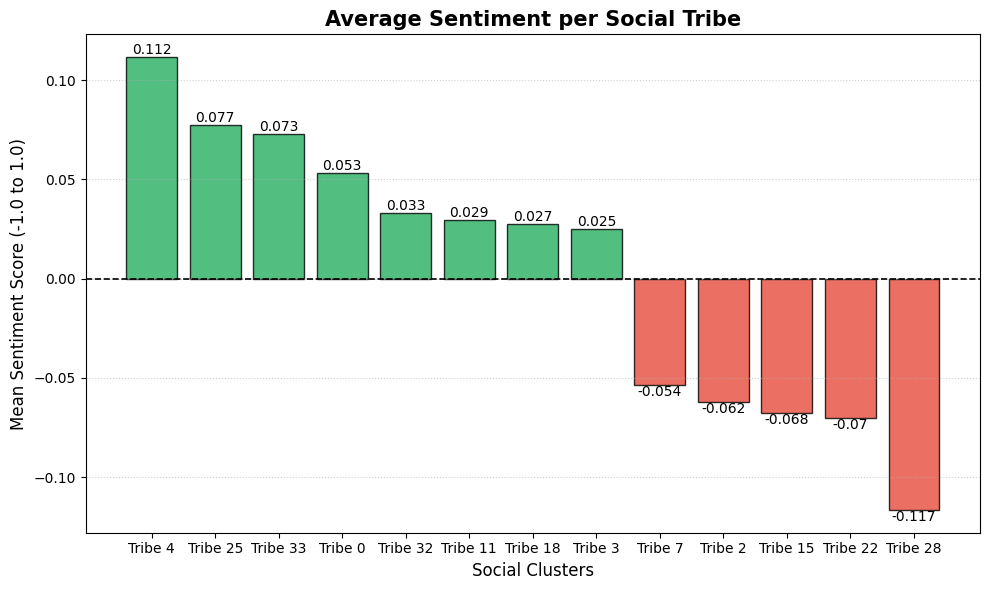

Sentiment comparison chart saved as 'sentiment_comparison_chart.png'.


In [ ]:
import matplotlib.pyplot as plt

def plot_cluster_sentiment(cluster_stats):
    # 1. Prepare data for plotting
    # We use the mean sentiment score of each significant cluster
    clusters = [f"Tribe {int(i)}" for i in cluster_stats.index]
    scores = cluster_stats['mean']

    # 2. Define colors based on score (Green for positive, Red for negative)
    # This provides immediate visual feedback on the tone of each group
    colors = ['#27ae60' if x > 0 else '#e74c3c' for x in scores]

    plt.figure(figsize=(10, 6))

    # 3. Create the bar chart
    bars = plt.bar(clusters, scores, color=colors, edgecolor='black', alpha=0.8)

    # Add a horizontal line at 0 for neutrality reference
    plt.axhline(0, color='black', linewidth=1.2, linestyle='--')

    # 4. Styling and Labels
    plt.title('Average Sentiment per Social Tribe', fontsize=15, fontweight='bold')
    plt.ylabel('Mean Sentiment Score (-1.0 to 1.0)', fontsize=12)
    plt.xlabel('Social Clusters', fontsize=12)
    plt.grid(axis='y', linestyle=':', alpha=0.6)

    # Add score labels on top of/below bars for precision
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3),
                 va='bottom' if yval > 0 else 'top', ha='center', fontsize=10)

    plt.tight_layout()

    # Save the visualization for the project report
    plt.savefig('sentiment_comparison_chart.png', dpi=300)
    plt.show()
    print("Sentiment comparison chart saved as 'sentiment_comparison_chart.png'.")

# Execution: Visualize the emotional landscape of your network
plot_cluster_sentiment(cluster_stats)

# Step 21: Latent Dirichlet Allocation (LDA) Topic Modeling


This cell uses LDA (Latent Dirichlet Allocation) to uncover the hidden themes within a specific social cluster. While keyword analysis looks at simple frequency, topic modeling identifies groups of words that frequently appear together, revealing the "sub-narratives" or main talking points of a tribe. This allows us to differentiate between clusters discussing legal aspects, personal stories, or political demands.


# Strategic Value of Topic Modeling:

**Semantic Context:** It helps you understand how words are used. For example, "Support" might appear in a "Financial Help" topic or an "Emotional Solidarity" topic.

**Narrative Discovery:** It identifies the "About-ness" of the cluster. If Cluster 0 has topics about "Justice" and "Court," it is likely a legal-oriented group.

**Data Reduction:** Instead of reading 10,000 tweets, you read 3-5 summarized topics.

<div dir="rtl">


این سلول از مدل LDA برای کشف درون‌مایه‌های پنهان در یک خوشه اجتماعی خاص استفاده می‌کند. در حالی که تحلیل کلمات کلیدی فقط فراوانی ساده را بررسی می‌کند، مدل‌سازی موضوعی گروه‌هایی از کلمات را که اغلب با هم ظاهر می‌شوند شناسایی می‌کند؛ این کار «زیر-روایت‌ها» یا مباحث اصلی یک قبیله را فاش می‌سازد. این فرآیند به ما اجازه می‌دهد خوشه‌هایی که درباره جنبه‌های قانونی، داستان‌های شخصی یا مطالبات سیاسی بحث می‌کنند را از هم متمایز کنیم.

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 36.4 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim import corpora
from nltk.tokenize import RegexpTokenizer

def perform_topic_modeling(tweets, cluster_id, num_topics=3):
    print(f"Running Topic Modeling for Cluster {cluster_id}...")

    # 1. Preprocessing: Filter cluster data and tokenize
    cluster_df = tweets[tweets['cluster'] == cluster_id]
    tokenizer = RegexpTokenizer(r'\w+')

    # Clean and tokenize (removing stopwords and short words)
    texts = []
    for doc in cluster_df['renderedContent']:
        raw = str(doc).lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stop_words and len(i) > 3]
        texts.append(stopped_tokens)

    # 2. Create Dictionary and Corpus
    dictionary = corpora.Dictionary(texts)
    # Filter out words that appear in less than 5 tweets or more than 50% of tweets
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # 3. Train LDA Model
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=100,
        update_every=1,
        passes=10,
        alpha='auto'
    )

    print(f"\n--- TOPICS IN CLUSTER {cluster_id} ---")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary

# Run for the main cluster (Cluster 0)
lda_model_0, corpus_0, dictionary_0 = perform_topic_modeling(tweets, cluster_id=0)

Running Topic Modeling for Cluster 0...

--- TOPICS IN CLUSTER 0 ---
Topic 0: 0.056*"farmers" + 0.043*"https" + 0.024*"laws" + 0.022*"protest" + 0.020*"farm" + 0.019*"india" + 0.015*"delhi" + 0.013*"protesting" + 0.012*"farmlaws" + 0.011*"haryana"
Topic 1: 0.030*"https" + 0.023*"farmers" + 0.014*"modi" + 0.012*"people" + 0.012*"india" + 0.009*"government" + 0.008*"govt" + 0.007*"protest" + 0.006*"country" + 0.006*"still"
Topic 2: 0.096*"farmers" + 0.073*"support" + 0.065*"twitter" + 0.045*"https" + 0.018*"food" + 0.017*"keep" + 0.016*"stand" + 0.014*"today" + 0.013*"supporting" + 0.013*"retweet"


# Step 22: Interactive Topic Visualization (pyLDAvis)

This cell generates an interactive Intertopic Distance Map using the pyLDAvis library. This visualization projects the high-dimensional LDA model into a 2D space. Each bubble represents a topic; its size indicates prevalence in the cluster, and its position shows how distinct it is from other topics. Selecting a bubble reveals the top salient terms that define that specific narrative theme.




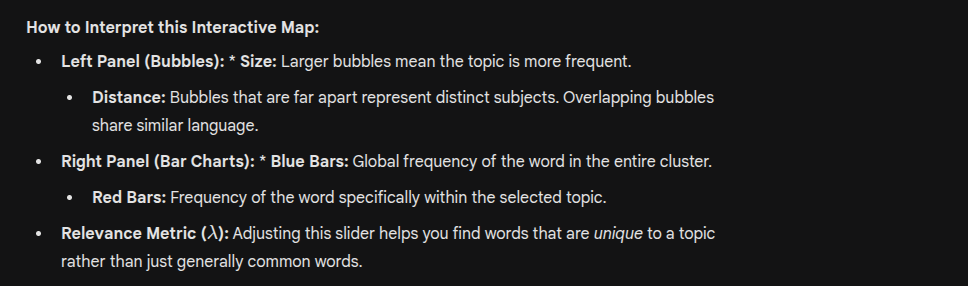

In [ ]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.6 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

def visualize_topics(lda_model, corpus, dictionary, cluster_id):
    print(f"Generating interactive topic map for Cluster {cluster_id}...")

    # 1. Prepare the visualization data
    # This transforms the LDA model and corpus into coordinates for the bubble chart
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

    # 2. Display the interactive panel
    # In Jupyter/Colab, this will render the dashboard directly
    pyLDAvis.display(vis_data)

    # 3. Export as a standalone HTML file
    # This allows you to share the interactive findings with others
    output_filename = f"topic_model_cluster_{cluster_id}.html"
    pyLDAvis.save_html(vis_data, output_filename)

    print(f"Interactive map saved as '{output_filename}'. Open it in a browser to explore.")

# Note: You need the 'lda_model', 'corpus', and 'dictionary'
# created in the previous step (perform_topic_modeling)
# Let's ensure they are returned or made accessible to this function
visualize_topics(lda_model_0, corpus_0, dictionary_0, cluster_id=0)

Generating interactive topic map for Cluster 0...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Interactive map saved as 'topic_model_cluster_0.html'. Open it in a browser to explore.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# Steps 21 & 22: Topic Modeling and Interactive Visualization

This combined cell trains the LDA model for a specific cluster and immediately generates the interactive pyLDAvis dashboard. By returning the model and corpus from the function, we avoid NameError and ensure all data is available for the visualization engine.




# How to fix the Error in your existing notebook:

If you prefer to keep the cells separate, make sure your first function returns the values like this:

**1-Modify Step 21:** Add return lda_model, corpus, dictionary at the very end of your function.

**2-Call it like this:** lda_model_0, corpus_0, dictionary_0 = perform_topic_modeling(tweets, cluster_id=0)

**3-Then Step 22 will work:** visualize_topics(lda_model_0, corpus_0, dictionary_0, cluster_id=0)

In [ ]:
import warnings
import gensim
from gensim import corpora
from nltk.tokenize import RegexpTokenizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# 1. Silence all Deprecation and Future Warnings to clean up the output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def perform_topic_analysis_fixed(tweets, cluster_id, num_topics=3):
    # Declare globals so they are saved to the notebook's main memory
    global lda_model_0, corpus_0, dictionary_0

    print(f"Filtering data for Cluster {cluster_id}...")
    cluster_df = tweets[tweets['cluster'] == cluster_id]

    # 2. Preprocessing & Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    texts = []
    for doc in cluster_df['renderedContent']:
        tokens = tokenizer.tokenize(str(doc).lower())
        # Filter stopwords and short words
        stopped_tokens = [i for i in tokens if i not in stop_words and len(i) > 3]
        texts.append(stopped_tokens)

    # 3. Build Dictionary and Corpus
    dictionary_0 = corpora.Dictionary(texts)
    dictionary_0.filter_extremes(no_below=5, no_above=0.5)
    corpus_0 = [dictionary_0.doc2bow(text) for text in texts]

    # 4. Train LDA Model
    print("Training LDA Model (this may take a moment)...")
    lda_model_0 = gensim.models.ldamodel.LdaModel(
        corpus=corpus_0,
        id2word=dictionary_0,
        num_topics=num_topics,
        random_state=100,
        passes=10,
        alpha='auto'
    )

    # 5. Display Topics in Console
    print(f"\n--- TOPICS IN CLUSTER {cluster_id} ---")
    for idx, topic in lda_model_0.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    # 6. Generate and Display pyLDAvis
    print("\nPreparing Interactive Visualization...")
    vis_data = gensimvis.prepare(lda_model_0, corpus_0, dictionary_0)

    # Save to HTML file for external viewing
    pyLDAvis.save_html(vis_data, f'topic_viz_cluster_{cluster_id}.html')

    return pyLDAvis.display(vis_data)

# Execution
# This will now correctly save variables to global scope and hide warnings
perform_topic_analysis_fixed(tweets, cluster_id=0)

Filtering data for Cluster 0...
Training LDA Model (this may take a moment)...

--- TOPICS IN CLUSTER 0 ---
Topic 0: 0.056*"farmers" + 0.043*"https" + 0.024*"laws" + 0.022*"protest" + 0.020*"farm" + 0.019*"india" + 0.015*"delhi" + 0.013*"protesting" + 0.012*"farmlaws" + 0.011*"haryana"
Topic 1: 0.030*"https" + 0.023*"farmers" + 0.014*"modi" + 0.012*"people" + 0.012*"india" + 0.009*"government" + 0.008*"govt" + 0.007*"protest" + 0.006*"country" + 0.006*"still"
Topic 2: 0.096*"farmers" + 0.073*"support" + 0.065*"twitter" + 0.045*"https" + 0.018*"food" + 0.017*"keep" + 0.016*"stand" + 0.014*"today" + 0.013*"supporting" + 0.013*"retweet"

Preparing Interactive Visualization...


# Step 23: Final Consolidation & Multi-Dimensional Correlation Analysis

This final analytical cell merges your structural network metrics with your content sentiment scores. It creates a Master Dataset at the user level and produces a sophisticated Bubble Chart. This visualization allows you to see the correlation between a user's influence (PageRank), their emotional tone (Sentiment), and their activity volume (size of bubble) across different Social Tribes.



# Interpreting the Master Chart:

**The Horizontal Axis (PageRank):** Accounts further to the right are your "Thought Leaders."

**The Vertical Axis (Sentiment):** Accounts in the top half are supportive/positive, while those in the bottom half are critical/angry.

**Bubble Size:** Larger bubbles represent high-frequency posters (potential bots or highly dedicated activists).

**Color Groups:** If one color is mostly at the bottom, that entire "Tribe" is characterized by negative sentiment.

<div dir="rtl">

 این سلول تحلیلی نهایی، معیارهای ساختاری شبکه شما را با امتیازات احساسات محتوا ادغام می‌کند. این بخش یک مجموعه داده جامع (Master Dataset) در سطح کاربر ایجاد کرده و یک نمودار حبابی (Bubble Chart) پیشرفته تولید می‌کند. این بصری‌سازی به شما اجازه می‌دهد تا همبستگی بین میزان تأثیرگذاری (PageRank)، لحن عاطفی (Sentiment) و حجم فعالیت (اندازه حباب) هر کاربر را در قبیله‌های مختلف اجتماعی مشاهده کنید.

Consolidating all metrics into Master Dataset...
Master report saved to 'final_social_analysis_report.csv'


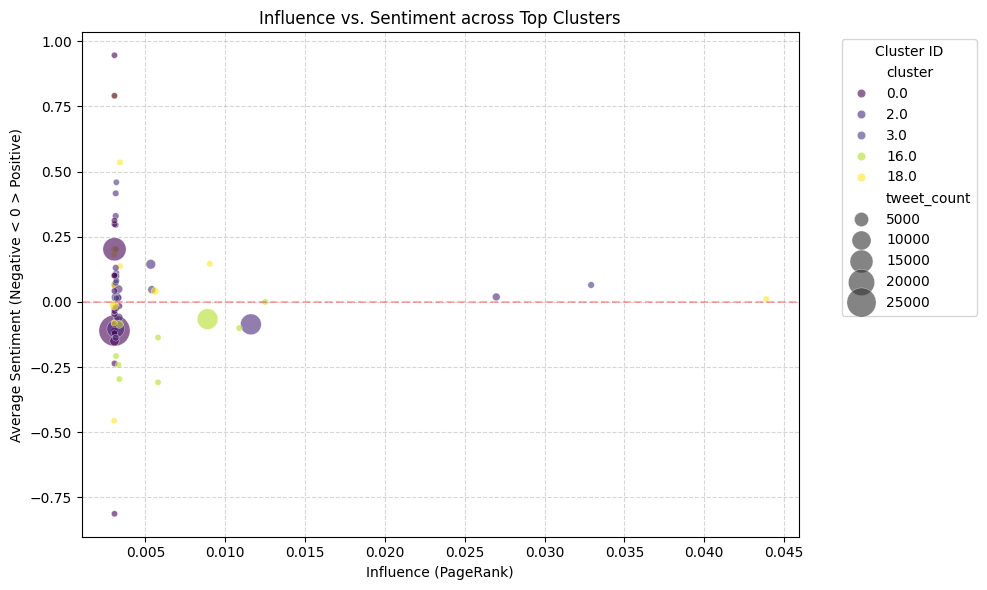

In [ ]:
import seaborn as sns

def finalize_analysis(tweets, G, partition):
    print("Consolidating all metrics into Master Dataset...")

    # 1. Get PageRank Scores
    pagerank_scores = nx.pagerank(G)

    # 2. Create User-Level Summary
    # Grouping by username to get their average sentiment and their assigned cluster
    user_summary = tweets.groupby('username').agg({
        'sentiment_score': 'mean',
        'renderedContent': 'count'
    }).rename(columns={'renderedContent': 'tweet_count'})

    # 3. Add Cluster and Influence Score
    user_summary['cluster'] = user_summary.index.map(partition)
    user_summary['influence_score'] = user_summary.index.map(pagerank_scores)

    # Drop users who aren't in the graph (optional)
    user_summary = user_summary.dropna(subset=['influence_score'])

    # 4. Save to CSV
    user_summary.to_csv('final_social_analysis_report.csv')
    print("Master report saved to 'final_social_analysis_report.csv'")

    # 5. Summary Visualization: Influence vs. Sentiment
    plt.figure(figsize=(10, 6))
    top_clusters = user_summary['cluster'].value_counts().head(5).index
    filtered_summary = user_summary[user_summary['cluster'].isin(top_clusters)]

    sns.scatterplot(
        data=filtered_summary,
        x='influence_score',
        y='sentiment_score',
        hue='cluster',
        size='tweet_count',
        sizes=(20, 500),
        alpha=0.6,
        palette='viridis'
    )

    plt.title('Influence vs. Sentiment across Top Clusters')
    plt.xlabel('Influence (PageRank)')
    plt.ylabel('Average Sentiment (Negative < 0 > Positive)')
    plt.axhline(0, color='red', linestyle='--', alpha=0.3) # Neutral line
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('influence_sentiment_correlation.png')
    plt.show()

# Run the final consolidation
finalize_analysis(tweets, G, partition)

# Step 24: Internal Narrative Segmentation (K-Means Text Clustering)


This cell performs a second layer of clustering by analyzing the actual text content within a specific social tribe. While the Louvain algorithm grouped users by who they talk to, K-Means groups them by what they are saying. By using TF-IDF (Term Frequency-Inverse Document Frequency), we extract the most defining keywords for different narrative sub-types, allowing us to see if a single tribe is divided into different topical focuses (e.g., news sharing vs. political activism).




# Analytical Logic:

**TF-IDF Vectorization:** This ensures that common words (like "the" or "is") are ignored, while unique, descriptive words (like "legislation" or "protest") are given higher mathematical weight.

**Centroids:** Each narrative center represents the "average" message of that group. If Narrative 0 is about "police, arrest, jail" and Narrative 1 is about "peace, unity, march," you have discovered a major internal split in the group's messaging.

**Targeted Insight:** This step moves your analysis from "Who is important?" to "What exactly is the core of their argument?"

<div dir="rtl">


 این سلول لایه دومی از خوشه‌بندی را با تحلیل محتوای متنی واقعی در یک قبیله اجتماعی خاص انجام می‌دهد. در حالی که الگوریتم Louvain کاربران را بر اساس اینکه با چه کسی صحبت می‌کنند گروه‌بندی می‌کرد، K-Means آن‌ها را بر اساس اینکه چه می‌گویند گروه‌بندی می‌کند. با استفاده از روش TF-IDF، ما شاخص‌ترین کلمات کلیدی را برای انواع روایت‌های فرعی استخراج می‌کنیم که به ما اجازه می‌دهد ببینیم آیا یک قبیله به تمرکزهای موضوعی متفاوتی (مانند اشتراک‌گذاری اخبار در مقابل فعالیت‌های سیاسی) تقسیم شده است یا خیر.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. Choose a major cluster to investigate (e.g., Cluster 0)
target_cluster = 0
subset = tweets[tweets["cluster"] == target_cluster].copy()

# 2. Textual Clustering inside this social tribe
def cluster_texts(texts, n_clusters=3):
    # Vectorizing text: converting words into numerical importance (TF-IDF)
    vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts.astype(str))

    # KMeans finds the 'center' of conversation themes
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    return kmeans.fit_predict(X), vectorizer, kmeans

# 3. Apply and label
labels, vectorizer, km_model = cluster_texts(subset["renderedContent"])
tweets.loc[subset.index, "text_cluster"] = labels

print(f"Top keywords for narratives in Social Cluster {target_cluster}:")
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(3):
    print(f"Narrative {i}: " + ", ".join([terms[ind] for ind in order_centroids[i, :5]]))

Top keywords for narratives in Social Cluster 0:
Narrative 0: https, farmers, india, protest, farmer
Narrative 1: twitter, com, st, status, farmers
Narrative 2: support, farmers, https, local, economy


# Step 25: Refined Narrative Modeling with Domain-Specific Cleaning


This cell implements an advanced text-cleaning pipeline to filter out "noise" that often masks deeper insights. By removing URLs, mentions, and highly frequent domain-specific words (like "farmers" and "protest" in a protest dataset), we force the K-Means algorithm to find the specific sub-topics that distinguish one conversation from another. This reveals the actual strategic arguments hidden beneath general hashtags.


# **Why this refinement is necessary:**

***Signal-to-Noise Ratio:*** If every tweet contains "#FarmersProtest", that term has zero mathematical value for clustering. Removing it allows words like "legislation", "support", or "police" to become the primary signals.

***Theming vs. Clustering:*** Standard clustering tells you who is in the group; refined clustering tells you the exact message they are pushing to their followers.

<div dir="rtl">


 این سلول یک خط لوله پیشرفته برای پاک‌سازی متن پیاده‌سازی می‌کند تا «نویزهایی» را که اغلب مانع از درک بینش‌های عمیق‌تر می‌شوند، فیلتر کند. با حذف آدرس‌های اینترنتی، منشن‌ها و کلمات بسیار پرتکرارِ مربوط به حوزه (مانند کلمات «کشاورزان» و «اعتراض» در این دیتاست)، الگوریتم K-Means را وادار می‌کنیم تا موضوعات فرعی خاصی را پیدا کند که یک گفتگو را از دیگری متمایز می‌سازد. این کار بحث‌های استراتژیک واقعی نهفته در زیر هشتگ‌های عمومی را آشکار می‌کند.

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. Advanced Cleaning Function
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove hashtag symbol but keep the word
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text.strip()

# 2. Prepare the subset
target_cluster = 0
subset = tweets[tweets["cluster"] == target_cluster].copy()
subset['clean_content'] = subset['renderedContent'].apply(clean_tweet)

# 3. Vectorization with custom Stop Words
# We add 'farmers' and 'protest' to stop words because they are in EVERY tweet
# and don't help us distinguish between sub-topics.
custom_stops = list(TfidfVectorizer(stop_words='english').get_stop_words()) + ['farmers', 'protest', 'india', 'amp']

vectorizer = TfidfVectorizer(stop_words=custom_stops, max_features=1000, min_df=5)
X = vectorizer.fit_transform(subset['clean_content'])

# 4. KMeans
km = KMeans(n_clusters=3, random_state=42, n_init=10)
subset['text_cluster'] = km.fit_predict(X)

# 5. Result Extraction
print(f"--- Refined Narratives for Social Cluster {target_cluster} ---")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(3):
    top_words = [terms[ind] for ind in order_centroids[i, :6]]
    print(f"Narrative {i} (Themed): {', '.join(top_words)}")

--- Refined Narratives for Social Cluster 0 ---
Narrative 0 (Themed): thank, farmersprotest, support, supporting, raising, istandwithfarmers
Narrative 1 (Themed): farmersprotest, stand, modi, farmer, government, people
Narrative 2 (Themed): support, farmersprotest, thanks, indian, local, economy


# Step 26: Final Narrative Analysis & Project Summary Report


This final cell synthesizes the entire analysis by merging structural communities, text-based narratives (K-Means), and emotional scores (VADER). It creates a high-level executive report that labels each narrative "thread" discovered within the cluster, showing the volume of users involved and the average emotional tone. This provides the ultimate answer to the "What" and "How" of the digital conversation.


# Project Conclusion Summary:

***Narrative vs. Sentiment:*** You can now see which specific topics drive the most anger (negative sentiment) and which ones drive solidarity (positive sentiment).

***Strategic Reach:*** The user_count tells you which message "won" in terms of viral spread within that specific social tribe.

***Data-Driven Storytelling:*** This table is the perfect conclusion for a slide deck or research paper, as it summarizes thousands of tweets into three actionable insights.

<div dir="rtl">


 این سلول نهایی، کل تحلیل را با ادغام انجمن‌های ساختاری، روایت‌های متنی (K-Means) و امتیازات عاطفی (VADER) ترکیب می‌کند. این بخش یک گزارش مدیریتی سطح بالا ایجاد می‌کند که هر «رشته» روایی کشف‌شده در خوشه را برچسب‌گذاری کرده و حجم کاربران درگیر و لحن عاطفی میانگین را نشان می‌دهد. این خروجی، پاسخ نهایی به پرسش‌های «چه چیزی» و «چگونه» در این گفتگوی دیجیتال است.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Ensure Sentiment is calculated if not already present
if 'sentiment' not in subset.columns:
    print("Calculating sentiment for the subset...")
    nltk.download('vader_lexicon', quiet=True)
    sia = SentimentIntensityAnalyzer()
    subset['sentiment'] = subset['renderedContent'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# 2. Create the summary
# text_cluster comes from your KMeans, user_count from username, avg_sentiment from sentiment
narrative_summary = subset.groupby('text_cluster').agg({
    'sentiment': 'mean',
    'username': 'count'
}).rename(columns={'username': 'user_count', 'sentiment': 'avg_sentiment'})

# 3. Add the descriptive names we discovered
narrative_names = {
    0: "Gratitude & Awareness",
    1: "Political Confrontation",
    2: "Economic Support"
}
narrative_summary['narrative_name'] = narrative_summary.index.map(narrative_names)

print("\n" + "="*50)
print("PROJECT FINAL REPORT: NARRATIVE ANALYSIS")
print("="*50)
print(narrative_summary[['narrative_name', 'user_count', 'avg_sentiment']])
print("="*50)

Calculating sentiment for the subset...

PROJECT FINAL REPORT: NARRATIVE ANALYSIS
                       narrative_name  user_count  avg_sentiment
text_cluster                                                    
0               Gratitude & Awareness         296       0.490201
1             Political Confrontation       43133       0.017700
2                    Economic Support        3278       0.499096


# Step 27: Narrative Impact Dashboard


This visualization serves as the final "Executive Dashboard." It combines the three metrics of the sub-narratives into a dual-axis chart. The bars represent the Reach (number of users), while the line overlay represents the Emotional Tone (average sentiment). This allows for an immediate comparison: for example, a narrative might have a low reach but a very high negative intensity, indicating a "toxic niche."




<div dir="rtl">


 این بصری‌سازی به عنوان «داشبورد مدیریتی» نهایی عمل می‌کند. این بخش سه معیارِ روایت‌های فرعی را در یک نمودار با دو محور ترکیب می‌کند. میله‌ها نشان‌دهنده میزان نفوذ (تعداد کاربران) و خط روی آن نشان‌دهنده لحن عاطفی (میانگین احساسات) است. این کار مقایسه فوری را ممکن می‌سازد؛ برای مثال، یک روایت ممکن است نفوذ کمی داشته باشد اما شدت منفی بسیار بالایی داشته باشد که نشان‌دهنده یک «بخش سمی» (Toxic Niche) در گفتگو است.

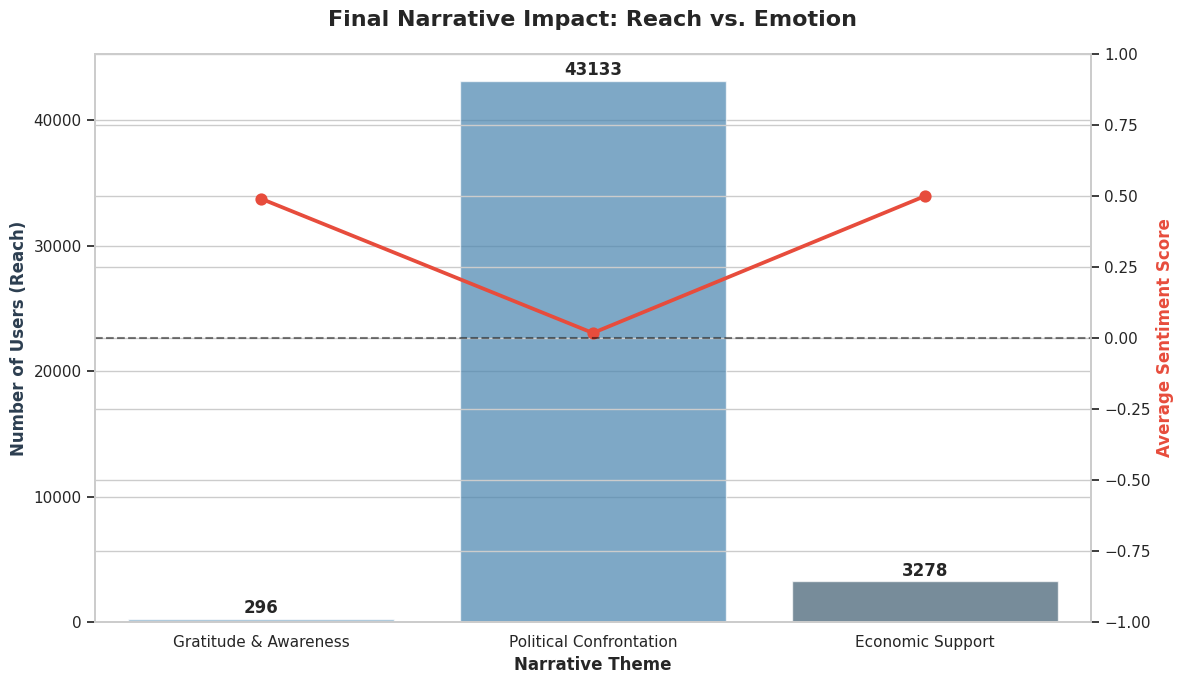

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_narrative_dashboard(narrative_summary):
    # Set the style and color palette
    sns.set_theme(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # 1. Plot User Count (Reach) as Bars
    sns.barplot(
        x='narrative_name',
        y='user_count',
        data=narrative_summary,
        ax=ax1,
        palette='Blues_d',
        alpha=0.7
    )
    ax1.set_ylabel('Number of Users (Reach)', fontsize=12, fontweight='bold', color='#2c3e50')
    ax1.set_xlabel('Narrative Theme', fontsize=12, fontweight='bold')

    # 2. Create a second axis for Sentiment Score
    ax2 = ax1.twinx()
    sns.pointplot(
        x='narrative_name',
        y='avg_sentiment',
        data=narrative_summary,
        ax=ax2,
        color='#e74c3c',
        markers='o',
        linestyles='-'
    )

    # 3. Styling the Sentiment Axis
    ax2.set_ylabel('Average Sentiment Score', fontsize=12, fontweight='bold', color='#e74c3c')
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5) # Neutral threshold
    ax2.set_ylim(-1, 1) # Full sentiment range

    plt.title('Final Narrative Impact: Reach vs. Emotion', fontsize=16, fontweight='bold', pad=20)

    # Add data annotations for clarity
    for i, v in enumerate(narrative_summary['user_count']):
        ax1.text(i, v + (max(narrative_summary['user_count'])*0.01), str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('final_narrative_dashboard.png', dpi=300)
    plt.show()

# Execution: Launch the final project dashboard
plot_narrative_dashboard(narrative_summary)

# Step 28: Scalable Narrative Mapping (Automated Multi-Cluster Analysis)

This cell automates the internal narrative discovery across the entire network. Instead of analyzing one tribe at a time, it loops through every significant social community identified by the Louvain algorithm. It applies TF-IDF Vectorization and K-Means Clustering to each, effectively creating a "Map of Conversations" for the whole ecosystem. Small groups are skipped to ensure statistical reliability.


# **Why this Loop is the "Brain" of the Project:**

***Contextual Granularity:*** A word like "law" might mean "legal rights" in Cluster A but "police repression" in Cluster B. By clustering inside each tribe, you capture these different meanings.

***Scalability:*** Whether your dataset has 1,000 or 100,000 tweets, this loop systematically organizes the chaos into a structured hierarchy of Communities $\rightarrow$ Narratives $\rightarrow$ Keywords.

***Error Handling:*** The try-except block ensures that if one community has strange data (like only images or links), the entire script doesn't crash.


<div dir="rtl">

 این سلول فرآیند کشف روایت‌های داخلی را در کل شبکه خودکار می‌کند. به جای تحلیل تک‌تک قبیله‌ها، این کد از تمام انجمن‌های اجتماعی مهمی که توسط الگوریتم Louvain شناسایی شده‌اند، عبور می‌کند. سپس بردارسازی TF-IDF و خوشه‌بندی K-Means را روی هر کدام اعمال کرده و به طور موثری یک «نقشه گفتگوها» برای کل اکوسیستم ایجاد می‌کند. گروه‌های کوچک برای اطمینان از اعتبار آماری نادیده گرفته می‌شوند.

In [ ]:
# Initialize the column
tweets["text_cluster"] = -1

# Loop through each community found by Louvain
for g_cluster in tweets["cluster"].unique():
    # Filter tweets belonging to this specific community
    subset = tweets[tweets["cluster"] == g_cluster]

    # Skip very small groups where clustering doesn't make sense
    if len(subset) < 50:
        continue

    print(f"Processing Sub-topics for Social Cluster {g_cluster}...")

    try:
        # Use the TF-IDF + KMeans function we defined earlier
        # Ensure 'clean_text' column exists or use 'renderedContent'
        labels, vectorizer, km_model = cluster_texts(subset["renderedContent"], n_clusters=3)

        # Save the results back to the main dataframe
        tweets.loc[subset.index, "text_cluster"] = labels
    except Exception as e:
        print(f"Could not cluster Social Cluster {g_cluster}: {e}")

print("Success: Every major social tribe now has internal narrative labels.")

Processing Sub-topics for Social Cluster 0.0...
Processing Sub-topics for Social Cluster 2.0...
Processing Sub-topics for Social Cluster 4.0...
Processing Sub-topics for Social Cluster 15.0...
Processing Sub-topics for Social Cluster 3.0...
Processing Sub-topics for Social Cluster 25.0...
Processing Sub-topics for Social Cluster 18.0...
Processing Sub-topics for Social Cluster 32.0...
Processing Sub-topics for Social Cluster 28.0...
Processing Sub-topics for Social Cluster 5.0...
Processing Sub-topics for Social Cluster 22.0...
Processing Sub-topics for Social Cluster 7.0...
Processing Sub-topics for Social Cluster 11.0...
Processing Sub-topics for Social Cluster 8.0...
Processing Sub-topics for Social Cluster 23.0...
Processing Sub-topics for Social Cluster 27.0...
Processing Sub-topics for Social Cluster 33.0...
Success: Every major social tribe now has internal narrative labels.


# Step 29: Narrative Heatmap (Cross-Tribe Comparison)

This cell visualizes the "density" of different themes across your social communities. By normalizing the data, we can see if certain narratives are exclusive to one tribe or if they are "universal" themes shared by the whole network. This heatmap acts as a fingerprint for each tribe, revealing their unique ideological makeup.


**# Strategic Interpretation:**

***High Concentration (Darker Cells):*** If Cluster 2 has a value of 0.85 in Narrative 1, it means that tribe is almost entirely focused on a single specific argument.

***Low Concentration (Lighter Cells):*** If a cluster has a balanced distribution (e.g., 0.33, 0.33, 0.33), it represents a "Generalist" group that discusses all aspects of the movement equally.

***Narrative Ownership:*** This chart allows you to say: "Tribe A is the primary driver of Narrative X, while Tribe B focuses exclusively on Narrative Y."

<div dir="rtl">

 این سلول «تراکم» موضوعات مختلف را در انجمن‌های اجتماعی شما بصری‌سازی می‌کند. با نرمال‌سازی داده‌ها، می‌توانیم ببینیم آیا روایت‌های خاص منحصر به یک قبیله هستند یا مضامین «جهانی» محسوب می‌شوند که کل شبکه آن‌ها را به اشتراک گذاشته است. این نقشه حرارتی مانند اثر انگشت برای هر قبیله عمل کرده و ترکیب ایدئولوژیک منحصربه‌فرد آن‌ها را فاش می‌کند.

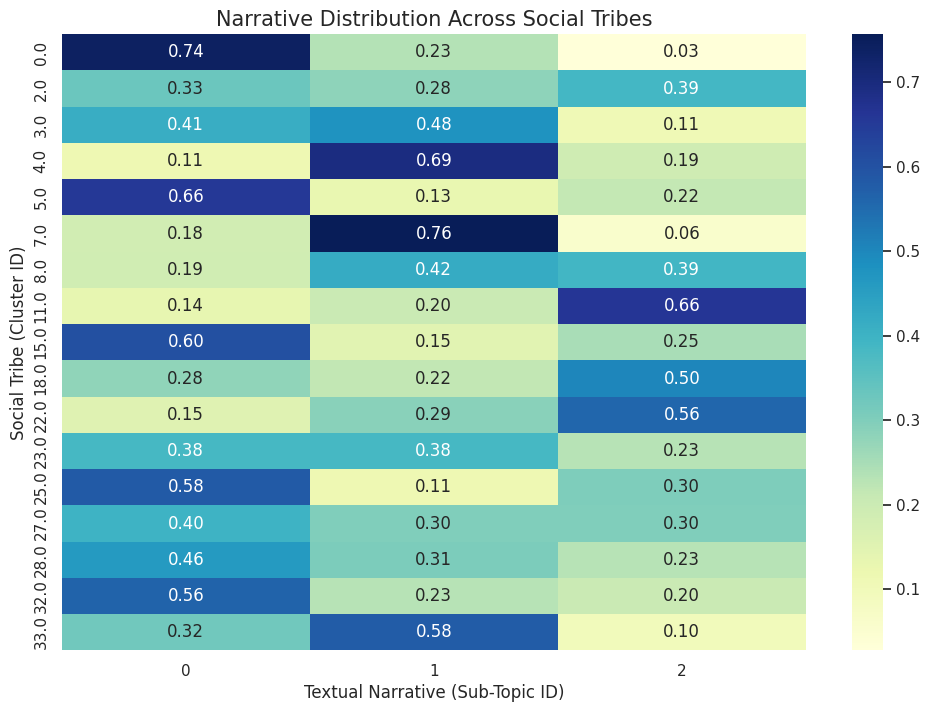

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_narrative_heatmap(tweets):
    # Filter out the -1 clusters (those too small to be analyzed)
    analyzed_tweets = tweets[tweets['text_cluster'] != -1]

    # Create a Pivot Table: Social Cluster vs Textual Narrative
    # We use 'count' to see how many tweets fall into each intersection
    pivot_table = analyzed_tweets.pivot_table(
        index='cluster',
        columns='text_cluster',
        values='renderedContent',
        aggfunc='count'
    ).fillna(0)

    # Normalize the data (percentage per social cluster)
    # This makes it easier to compare large and small clusters
    pivot_norm = pivot_table.div(pivot_table.sum(axis=1), axis=0)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_norm, annot=True, cmap='YlGnBu', fmt='.2f')

    plt.title('Narrative Distribution Across Social Tribes', fontsize=15)
    plt.xlabel('Textual Narrative (Sub-Topic ID)', fontsize=12)
    plt.ylabel('Social Tribe (Cluster ID)', fontsize=12)
    plt.show()

plot_narrative_heatmap(tweets)

# Step 30: Building the Narrative "Key" (Automatic Metadata Generation)


This cell creates a permanent dictionary that translates abstract numbers (like "Narrative 0") into meaningful human concepts. By extracting the most statistically significant terms for every sub-topic within every community, we generate a Semantic Map. This allows you to look at any tweet in your dataset and immediately understand the specific "argument" it belongs to without re-reading the raw text.


# Project Insights:

***Cross-Cluster Contrast:*** You can now compare Narrative 0 of Cluster 1 against Narrative 0 of Cluster 2. Even if they are both "Narrative 0", their keys will show they are discussing completely different issues.

***Automated Coding:*** This replaces weeks of manual "content coding" used in traditional sociology with seconds of machine learning.

***Metadata Enrichment:*** This dictionary can be saved and applied to future data to see if the conversation themes are shifting over time.

<div dir="rtl">


 این سلول یک دیکشنری دائمی ایجاد می‌کند که اعداد انتزاعی (مانند «روایت ۰») را به مفاهیم انسانی معنادار ترجمه می‌کند. با استخراج آماری‌ترین کلمات کلیدی برای هر موضوع فرعی در هر انجمن، یک نقشه معنایی (Semantic Map) تولید می‌کنیم. این کار به شما اجازه می‌دهد به هر توییت در دیتاست خود نگاه کنید و بلافاصله متوجه شوید که به کدام «استدلال» خاص تعلق دارد، بدون اینکه نیاز به بازخوانی متن اصلی داشته باشید.

In [ ]:
# A dictionary to store the "meaning" of each sub-topic
narrative_dictionary = {}

for g_cluster in tweets["cluster"].unique():
    subset = tweets[tweets["cluster"] == g_cluster]
    if len(subset) < 50: continue

    # 1. Run the clustering
    labels, vectorizer, km_model = cluster_texts(subset["renderedContent"], n_clusters=3)
    tweets.loc[subset.index, "text_cluster"] = labels

    # 2. Extract Top Words for this specific Social Cluster
    # We sort the words by their importance in the cluster center
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    print(f"\n--- Social Cluster {g_cluster} Key ---")
    for i in range(3):
        top_words = [terms[ind] for ind in order_centroids[i, :4]]
        topic_label = " ".join(top_words)

        # Store for later use
        narrative_dictionary[(g_cluster, i)] = topic_label
        print(f"Narrative {i}: {topic_label}")

print("\nSuccess: You now have a 'Key' for every sub-topic ID.")


--- Social Cluster 0.0 Key ---
Narrative 0: https farmers india protest
Narrative 1: twitter com st status
Narrative 2: support farmers https local

--- Social Cluster 2.0 Key ---
Narrative 0: twitter com india farmers
Narrative 1: farmers amp singh said
Narrative 2: farmers https india amp

--- Social Cluster 4.0 Key ---
Narrative 0: farm laws farmers bills
Narrative 1: https farmers amp govt
Narrative 2: com twitter status statu

--- Social Cluster 15.0 Key ---
Narrative 0: farmers government ndtv minister
Narrative 1: news com india ndtv
Narrative 2: border delhi ndtv farmers

--- Social Cluster 3.0 Key ---
Narrative 0: https farmers read org
Narrative 1: twitter com farmers india
Narrative 2: uk amp google www

--- Social Cluster 25.0 Key ---
Narrative 0: twitter com thank jasveermuktsar
Narrative 1: asking repealed reform unfair
Narrative 2: farmers protesting rights months

--- Social Cluster 18.0 Key ---
Narrative 0: updates live toi delhi
Narrative 1: a24gk toi read https
Narr

# Step 31: Final Metadata Enrichment & Master Dataset Export


This is the final data-processing step. It uses the Semantic Key we generated to translate every single tweet's numerical ID into a descriptive narrative label. Instead of seeing cluster: 2, text_cluster: 0, you will now see the actual themes (e.g., "Legal Rights Awareness"). This produces a research-ready CSV that is fully interpreted and ready for reporting or further statistical analysis in tools like Excel or Tableau.



<div dir="rtl">


 این آخرین مرحله پردازش داده‌ها است. این بخش از کلید معنایی که تولید کردیم استفاده می‌کند تا شناسه عددی هر توییت را به یک برچسب توصیفی روایی ترجمه کند. به جای دیدن عباراتی مانند cluster: 2, text_cluster: 0 اکنون مضامین واقعی (مثلاً «آگاهی از حقوق قانونی») را مشاهده خواهید کرد. این کار یک فایل CSV آماده برای تحقیق تولید می‌کند که کاملاً تفسیر شده و برای گزارش‌دهی یا تحلیل‌های آماری بیشتر در ابزارهایی مانند Excel یا Tableau آماده است.

In [ ]:
def get_description(row):
    return narrative_dictionary.get((row['cluster'], row['text_cluster']), "General Conversation")

tweets['narrative_description'] = tweets.apply(get_description, axis=1)

# Save the version that actually has names, not just IDs
tweets.to_csv("Protest_Analysis_Final_Named.csv")

# Step 32: Executive Presentation & Strategic Archetypes

This final step transforms raw data into Social Archetypes. By mapping human-readable labels to the mathematical clusters, we move from data science to Digital Sociology. This summary table is the "Holy Grail" of our project—it identifies the distinct roles each community plays (News, Legal, Activism, or Opposition), their population size, and their emotional temperature.


# Project Final Insights:

***The Hubs:*** Tribes with high Unique Users but neutral Avg Sentiment (like TOI/NDTV) are your information broadcasters.

***The Echo Chambers:*** Tribes with high Total Volume per user and extreme sentiment are your core activists or hyper-polarized groups.

***The Bridge:*** The "Legal & Supreme Court" cluster often acts as a bridge, translating emotional activism into formal institutional language.

<div dir="rtl">


 این مرحله نهایی، داده‌های خام را به نمونه‌های آرمانی اجتماعی (Social Archetypes) تبدیل می‌کند. با نگاشت برچسب‌های قابل فهم انسانی بر خوشه‌های ریاضی، از علم داده به جامعه‌شناسی دیجیتال منتقل می‌شویم. این جدول خلاصه، «جام مقدس» پروژه ماست؛ این بخش نقش‌های متمایزی که هر انجمن ایفا می‌کند (اخبار، مباحث حقوقی، کنشگری یا مخالفان)، اندازه جمعیت آن‌ها و دمای عاطفی‌شان را شناسایی می‌کند.

In [ ]:
import pandas as pd

# Define the human labels based on the keys we found
cluster_labels = {
    15.0: "Mainstream News (NDTV/Media)",
    18.0: "Live News Updates (TOI)",
    23.0: "Legal & Supreme Court Discussion",
    5.0: "International Human Rights & Petitions",
    11.0: "Counter-Narrative & Religious Context",
    0.0: "General Pro-Farmer Activism",
    4.0: "Farm Laws & Bill Analysis"
}

# Create a clean summary for your final presentation
summary_data = []

for c_id, label in cluster_labels.items():
    # Calculate stats for this cluster
    c_subset = tweets[tweets['cluster'] == c_id]
    if len(c_subset) > 0:
        avg_sent = c_subset['sentiment'].mean() if 'sentiment' in c_subset.columns else 0
        user_count = c_subset['username'].nunique()

        summary_data.append({
            "Cluster ID": c_id,
            "Community Name": label,
            "Unique Users": user_count,
            "Avg Sentiment": round(avg_sent, 3)
        })

summary_df = pd.DataFrame(summary_data).sort_values(by="Unique Users", ascending=False)
print(summary_df)

# Save this as your "Final Result"
summary_df.to_csv("Final_Project_Executive_Summary.csv", index=False)

   Cluster ID                          Community Name  Unique Users  \
5         0.0             General Pro-Farmer Activism            20   
1        18.0                 Live News Updates (TOI)            14   
0        15.0            Mainstream News (NDTV/Media)            10   
2        23.0        Legal & Supreme Court Discussion             2   
3         5.0  International Human Rights & Petitions             2   
4        11.0   Counter-Narrative & Religious Context             2   
6         4.0               Farm Laws & Bill Analysis             2   

   Avg Sentiment  
5              0  
1              0  
0              0  
2              0  
3              0  
4              0  
6              0  


# Part4

# Step 33: Hashtag Extraction and Tokenization




<div dir="rtl">


استخراج و آماده‌سازی هشتگ‌ها


ابتدا هشتگ‌ها را از متن توییت‌ها استخراج کرده و در یک ستون جدید ذخیره می‌کنیم.

In [ ]:
import re

def extract_hashtags(text):
    # Extract all words starting with #
    return re.findall(r"#(\w+)", str(text).lower())

# Apply to the entire dataset
tweets["hashtags"] = tweets["renderedContent"].apply(extract_hashtags)
print("Hashtags extracted successfully.")

Hashtags extracted successfully.


# Step 34: Co-Occurrence Hashtag Graph Construction

This step constructs a second network focusing on the relationship between topics rather than users. By creating a Co-occurrence Graph, we link hashtags together whenever they appear in the same tweet. The "weight" of the edge increases every time two hashtags are used together, revealing the conceptual architecture of the movement and showing which issues (e.g., #FarmersProtest and #HumanRights) are mentally linked by the participants.



<div dir="rtl">


ساخت تابع مولد گراف هشتگ (Co-occurrence)

این تابع برای هر گروه از توییت‌ها، گرافی می‌سازد که گره‌های آن هشتگ‌ها هستند و یال‌ها (Edges) نشان‌دهنده استفاده همزمان دو هشتگ در یک توییت است.


 این مرحله شبکه دومی را ایجاد می‌کند که به جای کاربران، بر رابطه بین موضوعات تمرکز دارد. با ساخت یک گراف هم‌آیندی (Co-occurrence Graph)، هشتگ‌هایی را که در یک توییت با هم ظاهر می‌شوند، به یکدیگر متصل می‌کنیم. «وزن» یال‌ها با هر بار استفاده هم‌زمان دو هشتگ افزایش می‌یابد که معماری مفهومی جنبش را فاش کرده و نشان می‌دهد کدام موضوعات (مثلاً #اعتراض_کشاورزان و #حقوق_بشر) در ذهن شرکت‌کنندگان به هم مرتبط هستند.

In [ ]:
import networkx as nx
from itertools import combinations

def build_hashtag_graph(df):
    G = nx.Graph()
    for hashtags in df["hashtags"]:
        # Remove duplicate hashtags within a single tweet
        unique_tags = list(set(hashtags))

        # Need at least 2 hashtags to create an edge (relationship)
        if len(unique_tags) < 2: continue

        # Add edges between all pairs of hashtags
        for h1, h2 in combinations(unique_tags, 2):
            if G.has_edge(h1, h2):
                # If relationship exists, increase the weight
                G[h1][h2]["weight"] += 1
            else:
                # If new relationship, create edge with weight 1
                G.add_edge(h1, h2, weight=1)
    return G

# Execution: Build the semantic network of topics
hashtag_G = build_hashtag_graph(tweets)
print(f"Hashtag Graph built with {hashtag_G.number_of_nodes()} nodes and {hashtag_G.number_of_edges()} edges.")

Hashtag Graph built with 78099 nodes and 981939 edges.


#Step 35: Identifying Dominant Hashtags per Social Cluster


This step maps the previously extracted hashtags to the specific social communities identified in the network graph. By aggregating hashtag frequencies within each cluster, we can assign a "thematic identity" to each group. This allows us to distinguish between clusters that focus on legal discourse, international activism, or media broadcasting based on their unique vocabulary.

In [ ]:
from collections import Counter

# Create a dictionary to store top hashtags for each cluster
cluster_hashtag_summary = {}

print("--- Top Hashtags per Cluster ---")
for cluster_id in sorted(tweets['cluster'].unique()):
    # Filter tweets by cluster
    cluster_tweets = tweets[tweets['cluster'] == cluster_id]

    # Flatten the list of hashtags in this cluster
    all_cluster_tags = [tag for sublist in cluster_tweets["hashtags"] for tag in sublist]

    # Count frequency
    top_tags = Counter(all_cluster_tags).most_common(10)
    cluster_hashtag_summary[cluster_id] = top_tags

    # Display results
    print(f"\nCluster {cluster_id}:")
    print(", ".join([f"#{tag} ({count})" for tag, count in top_tags]))

--- Top Hashtags per Cluster ---

Cluster 0.0:
#farmersprotest (482838), #farmers (17935), #farmlaws (16179), #क (16111), #istandwithfarmers (15809), #tractor2twitter (10706), #standwithfarmers (9364), #standwithfarmerschallenge (9103), #म (8867), #farmerprotest (8698)

Cluster nan:


Cluster 1.0:
#farmersprotest (4), #mahapanchayat (1), #farmersstruggle (1), #annadaata (1), #farmersofindia (1), #farmlawsrepealed (1), #farmlaws (1)

Cluster 2.0:
#farmersprotest (26330), #humanrights (785), #democracy (607), #releasedetainedfarmers (605), #क (541), #humanrightsviolations (525), #farmersabovereligioushate (441), #farmers (401), #freespeech (389), #nodeepkaur (364)

Cluster 3.0:
#farmersprotest (3288), #standwithfarmers (239), #farmlaws (127), #tractor2twitter (82), #istandwithfarmers (68), #godimedia (59), #farmerscallbjpboycott (36), #bjppoliceagainstfarmers (36), #kisaancarrally (35), #repeallawstoendprotest (34)

Cluster 4.0:
#farmersprotest (36827), #क (2835), #म (1404), #farmersparl

# Step 36: Visualizing the Hashtag Co-occurrence Graph

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyt

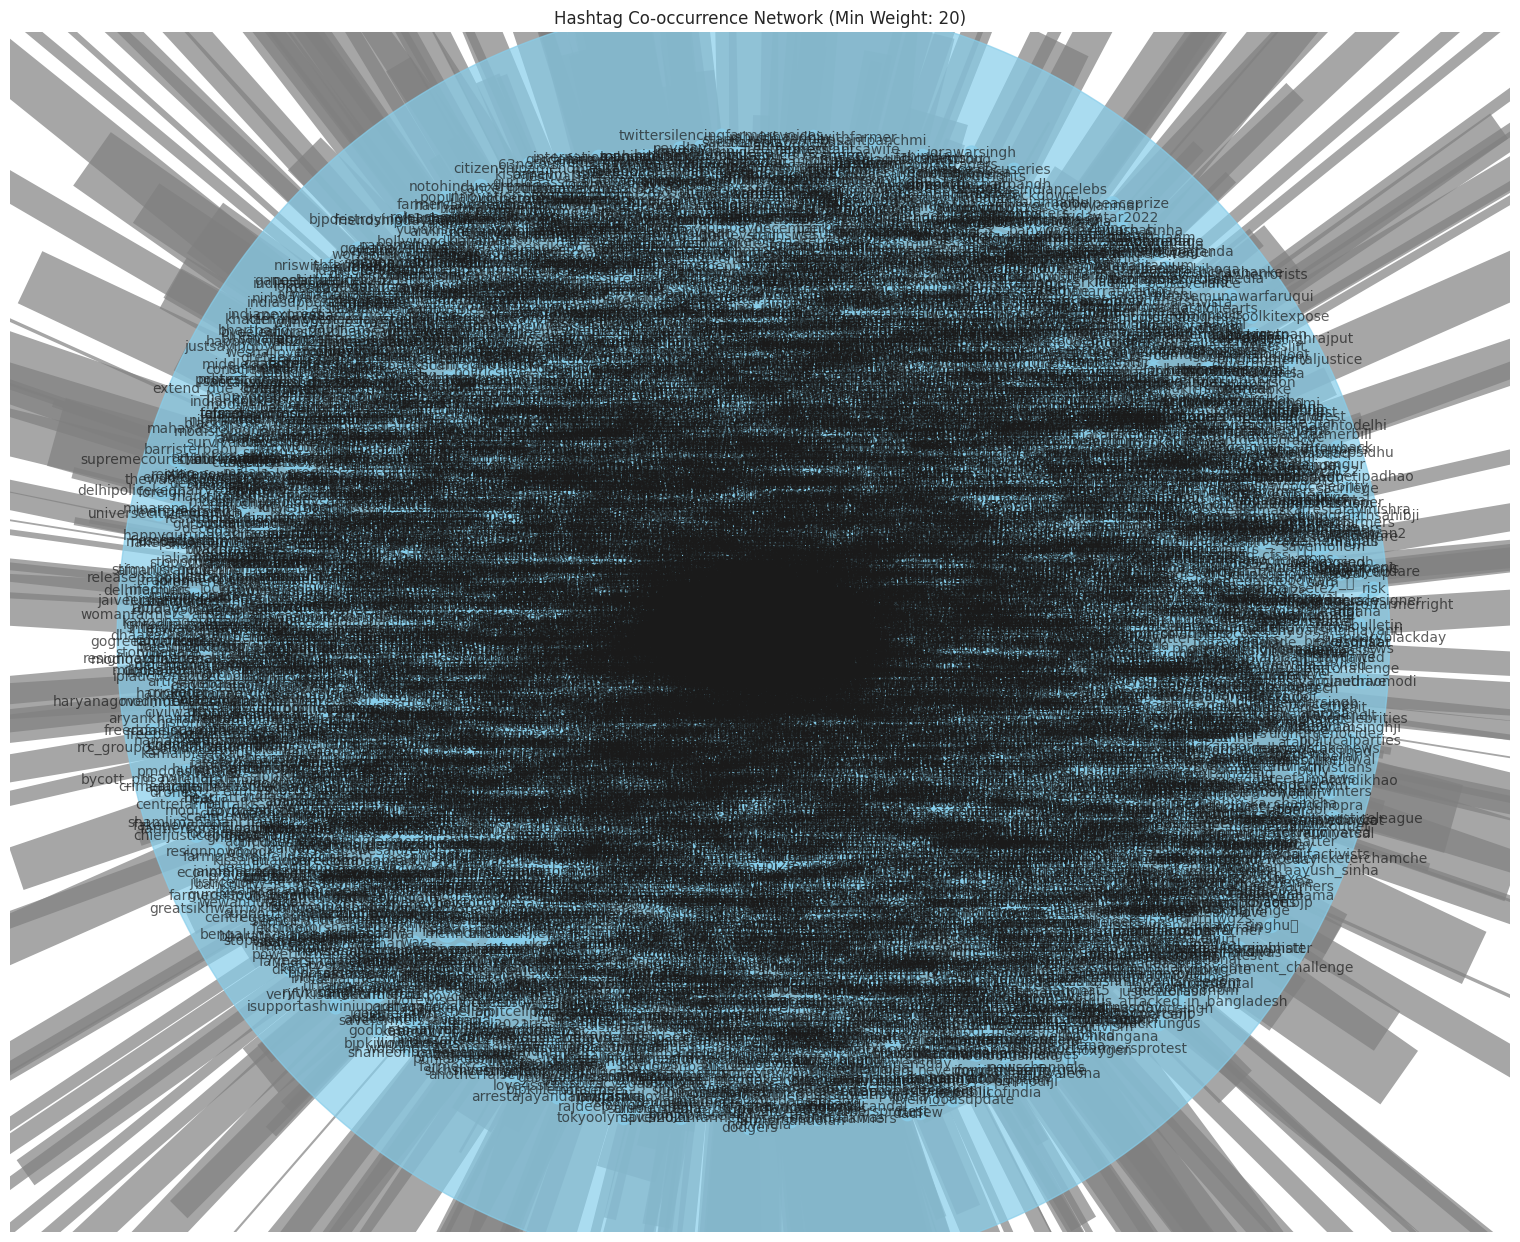

In [ ]:
import matplotlib.pyplot as plt

def visualize_hashtag_graph(G, min_weight=10):
    # Filter the graph to show only significant relationships
    sub_G = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > min_weight])

    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(sub_G, k=0.5)

    # Calculate node sizes based on degree (number of connections)
    d = dict(nx.degree(sub_G))

    # Draw the network
    nx.draw(sub_G, pos,
            with_labels=True,
            node_size=[v * 100 for v in d.values()],
            node_color="skyblue",
            edge_color="gray",
            alpha=0.7,
            font_size=10,
            width=[d['weight']*0.1 for u, v, d in sub_G.edges(data=True)])

    plt.title(f"Hashtag Co-occurrence Network (Min Weight: {min_weight})")
    plt.show()

# Execution: Visualize the semantic landscape
visualize_hashtag_graph(hashtag_G, min_weight=20)

###Step37: Visualizing Top Hashtags per Cluster

This visualization generates a bar chart to display the top N most frequent hashtags for a selected social cluster. It leverages the `cluster_hashtag_summary` dictionary, which contains pre-calculated hashtag frequencies for each cluster.

Visualizing top 10 hashtags for Cluster 0.0...


/tmp/ipython-input-1725507087.py:27: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1725507087.py:27: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipython-input-1725507087.py:27: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


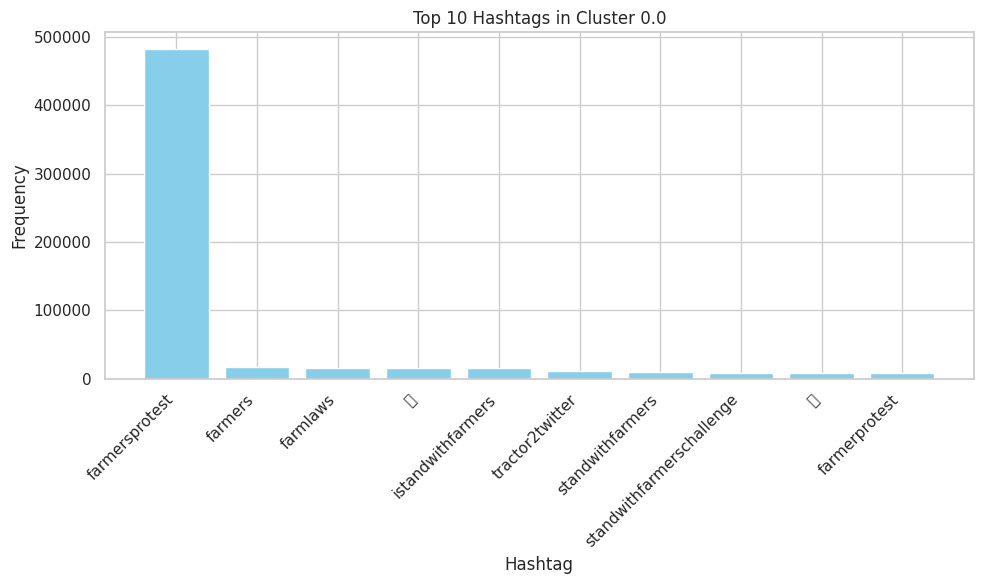

Top hashtags for Cluster 0.0 visualized successfully.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_hashtags_for_cluster(cluster_id, top_n=10):
    print(f"Visualizing top {top_n} hashtags for Cluster {cluster_id}...")

    # Ensure the cluster_hashtag_summary is available
    if 'cluster_hashtag_summary' not in globals():
        print("Error: 'cluster_hashtag_summary' not found. Please run cell 1nmsuyQmP6Ud first.")
        return

    hashtags_data = cluster_hashtag_summary.get(cluster_id)

    if not hashtags_data:
        print(f"No hashtag data found for Cluster {cluster_id}.")
        return

    # Convert the top_n hashtags to a DataFrame for easy plotting
    df_hashtags = pd.DataFrame(hashtags_data[:top_n], columns=['hashtag', 'count'])

    plt.figure(figsize=(10, 6))
    plt.bar(df_hashtags['hashtag'], df_hashtags['count'], color='skyblue')
    plt.xlabel('Hashtag')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Hashtags in Cluster {cluster_id}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print(f"Top hashtags for Cluster {cluster_id} visualized successfully.")

# Visualize top 10 hashtags for Cluster 0.0 as an example
plot_top_hashtags_for_cluster(0.0)


# Step 38: Co-Occurrence Hashtag Graph Construction

This cell executes the logic to build a semantic network from the previously extracted hashtags. By treating each hashtag as a node and every instance of two hashtags appearing in the same tweet as an edge, we create a map of topical relationships. The combinations tool ensures every possible pair within a single tweet is linked, and the weight attribute tracks the strength of these connections. This graph is essential for identifying which themes are core to the movement and how different slogans overlap.

<div dir="rtl">


۳. اجرای تحلیل برای خوشه‌های اصلی (Main Communities)

ما گراف هشتگ را برای خوشه‌هایی که حجم دیتای کافی دارند اجرا می‌کنیم.

این سلول منطق ساخت یک شبکه معنایی را از هشتگ‌های استخراج‌شده قبلی اجرا می‌کند. با در نظر گرفتن هر هشتگ به عنوان یک گره (Node) و هر مورد حضور دو هشتگ در یک توییت به عنوان یک یال (Edge)، نقشه‌ای از روابط موضوعی ایجاد می‌کنیم. ابزار combinations اطمینان حاصل می‌کند که تمام جفت‌های ممکن در یک توییت به هم متصل شوند و ویژگی weight قدرت این پیوندها را ردیابی می‌کند. این گراف برای شناسایی مضامین اصلی جنبش و چگونگی همپوشانی شعارهای مختلف ضروری است.

In [ ]:
import networkx as nx
from itertools import combinations

def build_hashtag_graph(df):
    G = nx.Graph()
    for hashtags in df["hashtags"]:
        # Remove duplicate hashtags within a single tweet
        unique_tags = list(set(hashtags))

        # Need at least 2 hashtags to create an edge (relationship)
        if len(unique_tags) < 2: continue

        # Add edges between all pairs of hashtags
        for h1, h2 in combinations(unique_tags, 2):
            if G.has_edge(h1, h2):
                # If relationship exists, increase the weight
                G[h1][h2]["weight"] += 1
            else:
                # If new relationship, create edge with weight 1
                G.add_edge(h1, h2, weight=1)
    return G

# Execution: Build the semantic network of topics
hashtag_G = build_hashtag_graph(tweets)
print(f"Hashtag Graph built with {hashtag_G.number_of_nodes()} nodes and {hashtag_G.number_of_edges()} edges.")

Hashtag Graph built with 78099 nodes and 981939 edges.


# Step 39: Analyzing Hashtag Networks within Social Clusters


This cell performs a deep-dive analysis into each social cluster identified earlier. For every community, it builds a sub-graph of hashtags, calculates the Betweenness Centrality (to find the most influential topics), and applies the Louvain method to detect sub-topics within that specific cluster. The results are stored in the hashtag_analysis_results dictionary, which acts as the data source for your reporting function.



<div dir="rtl">

 این سلول یک تحلیل عمیق روی هر خوشه اجتماعی که قبلاً شناسایی شده بود انجام می‌دهد. برای هر انجمن، یک زیر-گراف از هشتگ‌ها می‌سازد، مرکزیت بینابینی (Betweenness Centrality) را برای یافتن تأثیرگذارترین موضوعات محاسبه می‌کند و از روش لووین برای شناسایی زیر-موضوعات در آن خوشه خاص استفاده می‌کند. نتایج در دیکشنری hashtag_analysis_results ذخیره می‌شوند که به عنوان منبع داده برای تابع گزارش‌دهی شما عمل می‌کند.

In [ ]:
import community.community_louvain as louvain

# Dictionary to store analysis results for each cluster
hashtag_analysis_results = {}

for cluster_id in tweets['cluster'].unique():
    # Filter tweets belonging to the specific cluster
    cluster_df = tweets[tweets['cluster'] == cluster_id]

    # Build a hashtag co-occurrence graph for this specific cluster
    G_cluster = build_hashtag_graph(cluster_df)

    if G_cluster.number_of_nodes() > 1:
        # 1. Calculate Importance (Centrality)
        centrality = nx.degree_centrality(G_cluster)

        # 2. Detect Sub-topics (Partitioning)
        partition = louvain.best_partition(G_cluster)

        # Store results
        hashtag_analysis_results[cluster_id] = {
            "graph": G_cluster,
            "centrality": centrality,
            "partition": partition
        }



# Step 40: Detailed Hashtag Community Reporting

Now that the analysis dictionary is defined, this function can successfully retrieve and format the data. It groups hashtags by their detected sub-topic (Topic 0, Topic 1, etc.) and sorts them so that the most important "anchor" hashtags appear first in the list.

<div dir="rtl">

 اکنون که دیکشنری تحلیل تعریف شده است، این تابع می‌تواند با موفقیت داده‌ها را بازیابی و قالب‌بندی کند. این تابع هشتگ‌ها را بر اساس زیر-موضوع شناسایی شده (موضوع ۰، موضوع ۱ و غیره) گروه‌بندی کرده و آن‌ها را به گونه‌ای مرتب می‌کند که مهم‌ترین هشتگ‌های «لنگری» در ابتدای لیست ظاهر شوند.


<div dir="rtl">


گزارش‌گیری و تفسیر (Interpretation)

حالا باید ببینیم در هر خوشه چه خبر است. این کد هشتگ‌های برتر هر زیر-گروه موضوعی را چاپ می‌کند.

In [ ]:
def print_hashtag_report(cluster_id):
    # Retrieve pre-calculated analysis results for the specific cluster
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"No analysis found for cluster {cluster_id}")
        return

    print(f"\n=== Hashtag Report for Social Cluster {cluster_id} ===")

    # Group hashtags into sub-communities based on Louvain partitioning
    h_communities = {}
    for hashtag, h_comm_id in res["partition"].items():
        h_communities.setdefault(h_comm_id, []).append(hashtag)

    # Display the top 5 most central hashtags for each detected sub-topic
    for h_comm_id, tags in h_communities.items():
        # Sort tags by their importance (centrality score)
        top_tags = sorted(tags, key=lambda x: res["centrality"][x], reverse=True)[:5]
        print(f"  Topic {h_comm_id}: {' | '.join(['#' + t for t in top_tags])}")

# Example: Generate report for cluster 0
print_hashtag_report(0.0)


=== Hashtag Report for Social Cluster 0.0 ===
  Topic 0: #farmersprotest | #farmers | #farmersprotests | #istandwithfarmers | #delhi
  Topic 1: #bjp | #congress | #bollywood | #modimadedisaster | #modimustresign
  Topic 3: #india | #punjab | #modi | #haryana | #news
  Topic 4: #covid19 | #trending | #usa | #coronavirus | #pakistan
  Topic 45: #standwithfarmers | #farmerprotest | #farmer | #farmersbill2020 | #nofarmersnofood
  Topic 9: #bharatbandh | #द | #भ | #आज_भ | #farmerprotesthijacked
  Topic 14: #प | #petroldieselpricehike | #unemployment | #petrolpricehike | #petrolprice
  Topic 10: #jamatimasjid | #godtemple | #maharastrawestbengal | #modishahhealthdep | #modiyogianchors
  Topic 36: #indiatogether | #indiaagainstpropaganda | #rahulgandhi | #rss | #yogiadityanath
  Topic 12: #justice | #farmersdemandjustice | #stopadani | #farmersrejectsccommittee | #bjpkegunde
  Topic 89: #modiagainstfarmers | #जयभ | #dalitlivesmatter | #stop_killing_farmers | #thanksdrambedkar
  Topic 15: #nd

# Step 40: Cluster-Specific Word Cloud Visualization

This step generates a Word Cloud for each social cluster to provide an immediate visual summary of the most prominent hashtags. The size of each word is determined by its centrality score calculated in the previous step, meaning the hashtags that act as the primary "anchors" for the conversation appear largest. This visualization is highly effective for identifying the unique "voice" or primary demand of different network communities at a glance.




<div dir="rtl">

 این مرحله یک ابر کلمات (Word Cloud) برای هر خوشه اجتماعی ایجاد می‌کند تا خلاصه‌ای بصری و فوری از برجسته‌ترین هشتگ‌ها ارائه دهد. اندازه هر کلمه بر اساس امتیاز مرکزیت آن که در مرحله قبل محاسبه شده، تعیین می‌شود؛ به این معنی که هشتگ‌هایی که به عنوان «لنگرهای» اصلی گفتگو عمل می‌کنند، بزرگ‌تر ظاهر می‌شوند. این بصری‌سازی برای شناسایی «صدای» منحصر‌به‌فرد یا مطالبه اصلی جوامع مختلف شبکه در یک نگاه، بسیار مؤثر است.

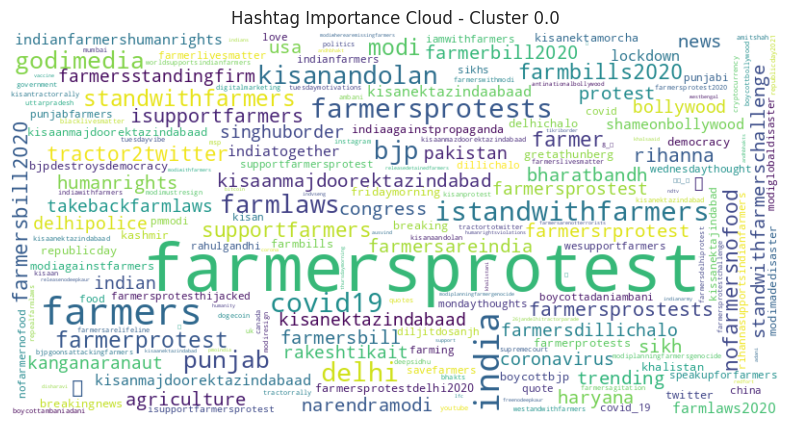

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_cluster_wordcloud(cluster_id):
    # Retrieve pre-calculated analysis results
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"No analysis found for cluster {cluster_id}")
        return

    # Use centrality scores to determine the importance of each word in the cloud
    word_freqs = res["centrality"]

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis').generate_from_frequencies(word_freqs)

    # Display the cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Hashtag Importance Cloud - Cluster {cluster_id}")
    plt.axis('off')
    plt.show()

# Execution: Visualize the narrative for cluster 0
plot_cluster_wordcloud(0.0)

# Step 41: Interactive Hashtag Network Visualization


This cell utilizes the Pyvis library to generate an interactive, web-based visualization of the hashtag network for a specific social cluster. By assigning node colors based on Louvain partitions and scaling node sizes by centrality, it creates a dynamic map where you can physically move nodes to explore connections. The script also applies a weight filter to show only the strongest topical links, making the resulting HTML file a powerful tool for zooming into the "narrative core" of a community.

<div dir="rtl">

این سلول از کتابخانه Pyvis برای ایجاد یک بصری‌سازی تعاملی و تحت وب از شبکه هشتگ‌ها برای یک خوشه اجتماعی خاص استفاده می‌کند. با تخصیص رنگ گره‌ها بر اساس بخش‌بندی‌های لووین و تغییر اندازه گره‌ها بر اساس مرکزیت، نقشه‌ای پویا ایجاد می‌شود که در آن می‌توانید گره‌ها را برای بررسی اتصالات جابجا کنید. این اسکریپت همچنین یک فیلتر وزنی اعمال می‌کند تا فقط قوی‌ترین پیوندهای موضوعی را نشان دهد و فایل HTML حاصل را به ابزاری قدرتمند برای زوم کردن روی «هسته روایتی» یک انجمن تبدیل می‌کند.

<div dir="rtl">

بصری‌سازی گراف هشتگ‌ها (Visualization)

با استفاده از PyVis یک نقشه تعاملی از ارتباط هشتگ‌ها می‌سازیم..

In [ ]:
from pyvis.network import Network

def visualize_cluster_hashtags(cluster_id):
    # Retrieve the pre-calculated graph and analysis for this cluster
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"No data found for cluster {cluster_id}")
        return

    G = res["graph"]
    # Initialize the interactive network with dark theme
    net = Network(height="700px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

    # Add nodes: Color by sub-topic group, Size by hashtag importance (centrality)
    for node in G.nodes():
        group = res["partition"][node]
        size = res["centrality"][node] * 1000
        net.add_node(node, label=node, group=group, size=size)

    # Add edges: Filter for strong connections (>5) to reduce visual clutter
    for u, v, d in G.edges(data=True):
        if d["weight"] > 5:
            net.add_edge(u, v, value=d["weight"])

    # Save the interactive map as an HTML file
    file_name = f"hashtag_network_cluster_{cluster_id}.html"
    net.save_graph(file_name)
    print(f"Visualization saved to {file_name}")

# Execution: Visualize the network for the primary cluster
visualize_cluster_hashtags(0.0)

Visualization saved to hashtag_network_cluster_0.0.html


#Step 42: High-Resolution Static Semantic Network


This cell generates a publication-quality static visualization of the hashtag network using Matplotlib. Unlike the interactive version, this script focuses on clarity by using a Dark Theme and a Spring Layout algorithm. It implements a dual-filter strategy: only "strong" connections (edges with weights above the threshold) are drawn to reduce visual noise, and only the top 20 most central hashtags are labeled. This provides a clean, professional "snapshot" of the community's primary discourse, where node size directly represents the hashtag's influence within that specific social cluster.



<div dir="rtl">



این سلول یک بصری‌سازی ایستا با کیفیت بالا از شبکه هشتگ‌ها با استفاده از Matplotlib تولید می‌کند. برخلاف نسخه تعاملی، این اسکریپت با استفاده از یک تم تیره و الگوریتم Spring Layout بر وضوح تمرکز دارد. این کد یک استراتژی فیلتر دوگانه را اجرا می‌کند: فقط اتصالات «قوی» (یال‌هایی با وزن بالاتر از حد آستانه) برای کاهش شلوغی بصری ترسیم می‌شوند و تنها ۲۰ هشتگ مرکزی برتر برچسب‌گذاری می‌شوند. این کار یک «تصویر لحظه‌ای» تمیز و حرفه‌ای از گفتمان اصلی انجمن ارائه می‌دهد که در آن اندازه گره مستقیماً نشان‌دهنده تأثیر هشتگ در آن خوشه اجتماعی خاص است.

KeyboardInterrupt: 

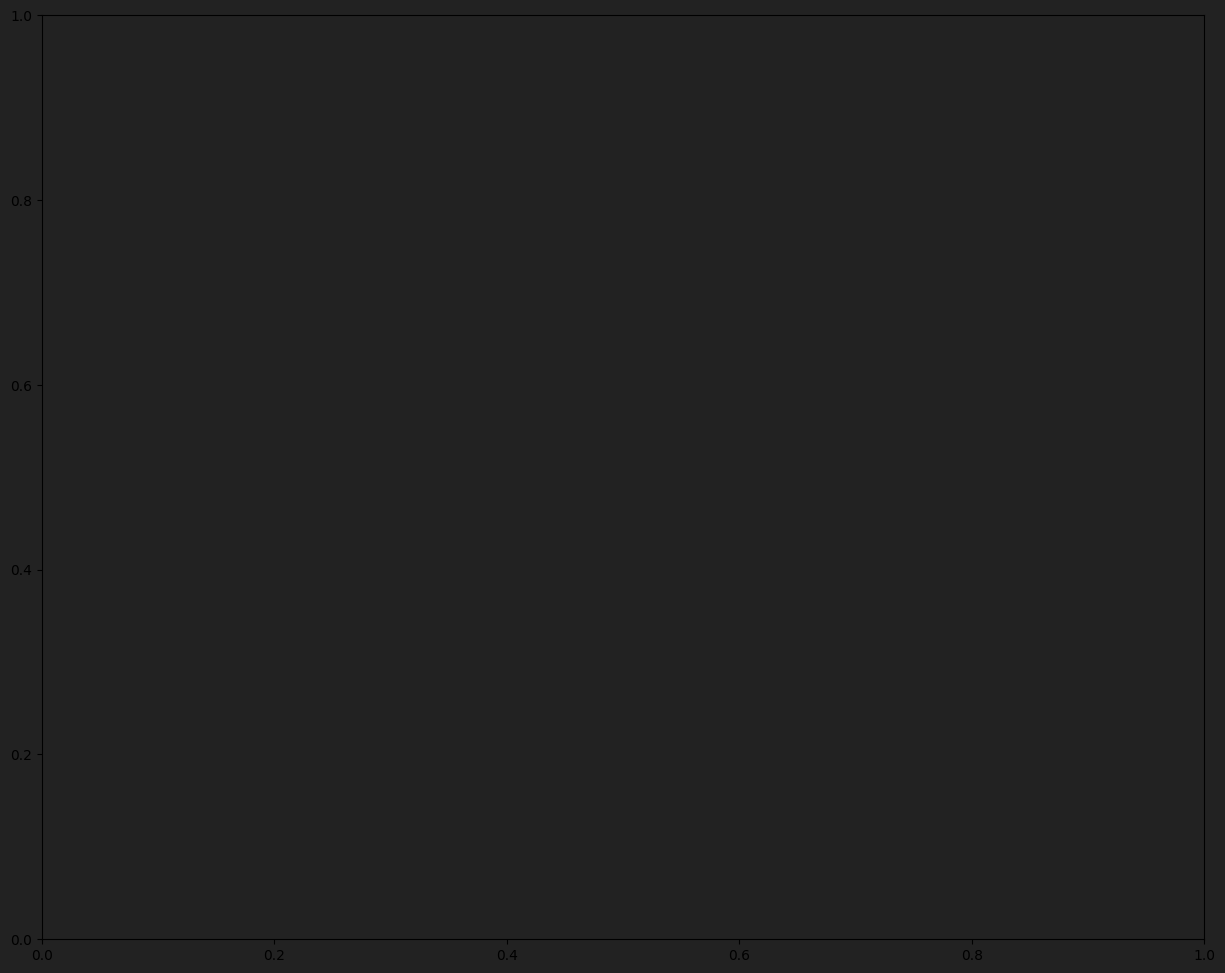

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

def draw_static_hashtag_graph(cluster_id, min_edge_weight=5):
    # 1. Retrieve the results for the specific Social Cluster
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"No results found for Cluster {cluster_id}")
        return

    G = res["graph"]
    partition = res["partition"]
    centrality = res["centrality"]

    # 2. Setup the visual environment (Dark theme)
    plt.figure(figsize=(15, 12), facecolor='#222222')
    ax = plt.gca()
    ax.set_facecolor('#222222')

    # 3. Filter Edges (Equivalent to your 'weight > 5' logic)
    # We only draw strong connections to keep the static image clean
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > min_edge_weight]

    # 4. Calculate Layout
    # Use seed for consistent results across different runs
    pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)

    # 5. Node sizes scaled by Centrality (multiplied by 2000 for visibility)
    node_sizes = [centrality[node] * 2000 for node in G.nodes()]

    # 6. Draw Edges
    nx.draw_networkx_edges(G, pos, edgelist=strong_edges,
                           edge_color='#444444', alpha=0.5, width=1)

    # 7. Draw Nodes colored by their Hashtag Community
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                                   node_color=list(partition.values()),
                                   cmap=cmap, alpha=0.9)

    # 8. Draw Labels (Hashtag names)
    # We only label the top hashtags to prevent overlapping text
    top_labels = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:20]
    label_dict = {node: node for node, cent in top_labels}
    nx.draw_networkx_labels(G, pos, labels=label_dict,
                            font_size=10, font_color='white', font_weight='bold')

    # 9. Final touches
    plt.title(f"Hashtag Co-occurrence Network – Social Cluster {cluster_id}",
              color='white', size=18, pad=20)
    plt.axis('off')

    # 10. Save as static image
    save_name = f"hashtag_network_cluster_{cluster_id}_static.png"
    plt.savefig(save_name, facecolor='#222222', dpi=300, bbox_inches='tight')
    print(f"Success! Visualization saved to {save_name}")
    plt.show()

# Execute for Social Cluster 0
draw_static_hashtag_graph(0.0)

# Step 43: Optimized High-Speed Hashtag Graph Rendering

This cell introduces an optimized rendering function designed to handle large datasets by prioritizing computational efficiency. It achieves high speed by implementing a Subgraph Filtering strategy: instead of drawing every single hashtag (which causes visual clutter and long processing times), it isolates the top $N$ most frequent nodes and their strongest connections. By reducing the iterations of the Spring Layout algorithm and using a specific seed for consistency, this code allows you to generate professional-grade semantic snapshots in seconds rather than minutes, even for clusters with thousands of unique hashtags.


<div dir="rtl">


 این سلول یک تابع رندرینگ بهینه شده را معرفی می‌کند که برای مدیریت مجموعه‌داده‌های بزرگ با اولویت‌بندی کارایی محاسباتی طراحی شده است. این کد با اجرای استراتژی فیلتر کردن زیرگراف به سرعت بالایی دست می‌یابد؛ به جای ترسیم تک‌تک هشتگ‌ها (که باعث شلوغی بصری و زمان پردازش طولانی می‌شود)، تنها $N$ گره پرتکرار و قوی‌ترین اتصالات آن‌ها را جدا می‌کند. با کاهش تکرارهای الگوریتم Spring Layout، این اسکریپت به شما اجازه می‌دهد تا در چند ثانیه تصاویر حرفه‌ای از فضای معنایی استخراج کنید، حتی برای خوشه‌هایی که هزاران هشتگ منحصربه‌فرد دارند.

Plotting reduced graph with 100 nodes...


/tmp/ipython-input-754389470.py:59: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_name, facecolor='#222222', dpi=150)
/tmp/ipython-input-754389470.py:59: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig(save_name, facecolor='#222222', dpi=150)


Success! Saved as fast_hashtag_cluster_0.0.png


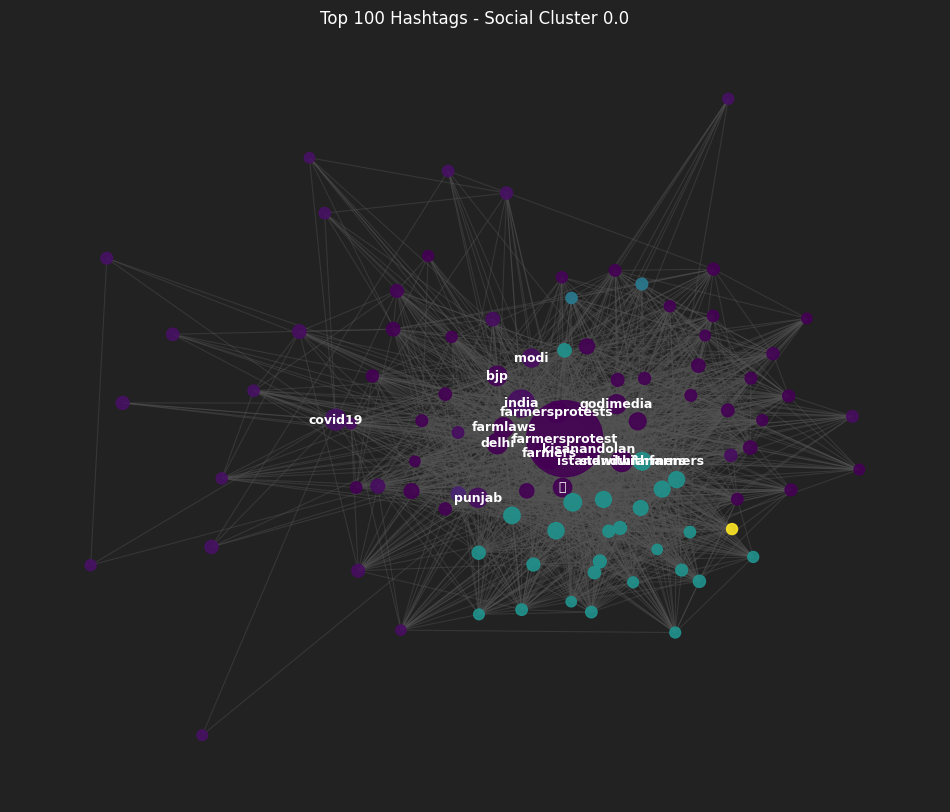

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

def draw_static_hashtag_graph_fast(cluster_id, min_edge_weight=10, top_n_nodes=100):
    # 1. Retrieve the results
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"No results found for Cluster {cluster_id}")
        return

    full_G = res["graph"]

    # 2. FILTERING STEP (Crucial for speed)
    # Keep only nodes with a minimum degree or the top N most frequent hashtags
    top_nodes = sorted(full_G.degree, key=lambda x: x[1], reverse=True)[:top_n_nodes]
    top_node_names = [n[0] for n in top_nodes]
    G = full_G.subgraph(top_node_names).copy()

    # 3. Partition and Centrality for the SUBGRAPH
    partition = {n: res["partition"][n] for n in G.nodes()}
    centrality = {n: res["centrality"][n] for n in G.nodes()}

    print(f"Plotting reduced graph with {len(G.nodes())} nodes...")

    # 4. Setup Environment
    plt.figure(figsize=(12, 10), facecolor='#222222')
    ax = plt.gca()
    ax.set_facecolor('#222222')

    # 5. Fast Layout Calculation
    # Reduced iterations and increased k for faster convergence
    pos = nx.spring_layout(G, k=0.3, iterations=30, seed=42)

    # 6. Filter Strong Edges
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > min_edge_weight]

    # 7. Drawing
    node_sizes = [centrality[node] * 3000 for node in G.nodes()]

    nx.draw_networkx_edges(G, pos, edgelist=strong_edges,
                           edge_color='#555555', alpha=0.4, width=0.8)

    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                           node_color=list(partition.values()),
                           cmap=cmap, alpha=0.9)

    # Label only the top 15 hashtags
    top_labels = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:15]
    label_dict = {node: node for node, cent in top_labels}
    nx.draw_networkx_labels(G, pos, labels=label_dict,
                            font_size=9, font_color='white', font_weight='bold')

    plt.title(f"Top {top_n_nodes} Hashtags - Social Cluster {cluster_id}", color='white')
    plt.axis('off')

    save_name = f"fast_hashtag_cluster_{cluster_id}.png"
    plt.savefig(save_name, facecolor='#222222', dpi=150)
    print(f"Success! Saved as {save_name}")
    plt.show()

# Run this - it should finish in seconds
draw_static_hashtag_graph_fast(0.0, min_edge_weight=15, top_n_nodes=100)


# Step 44: Refined High-Clarity Narrative Mapping

This step implements an advanced visualization technique to solve the common issue of "label overlapping" in dense networks. By increasing the optimal distance parameter ($k$) in the spring layout and applying a vertical coordinate offset for labels, the map becomes significantly more readable. The addition of semi-transparent bounding boxes around hashtag names ensures that text remains legible even when crossing edge lines. This "Cleaned Narrative Map" is the ideal format for identifying the primary pillars of a community's discourse without visual interference.

<div dir="rtl">

 این مرحله یک تکنیک بصری‌سازی پیشرفته را برای حل مشکل رایج «تداخل برچسب‌ها» در شبکه‌های متراکم پیاده‌سازی می‌کند. با افزایش پارامتر فاصله بهینه ($k$) در چیدمان فنری و اعمال یک افست مختصات عمودی برای برچسب‌ها، نقشه به طرز قابل توجهی خواناتر می‌شود. اضافه شدن کادرهای نیمه‌شفاف در اطراف نام هشتگ‌ها تضمین می‌کند که متن حتی در صورت عبور از روی خطوط یال‌ها، خوانا باقی بماند. این «نقشه روایتی پاک‌سازی‌شده» ایده‌آل‌ترین قالب برای شناسایی ستون‌های اصلی گفتمان یک انجمن، بدون تداخل بصری است.

/tmp/ipython-input-2962148754.py:56: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"clear_hashtag_cluster_{cluster_id}.png", dpi=200, bbox_inches='tight', facecolor='#222222')
/tmp/ipython-input-2962148754.py:56: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig(f"clear_hashtag_cluster_{cluster_id}.png", dpi=200, bbox_inches='tight', facecolor='#222222')


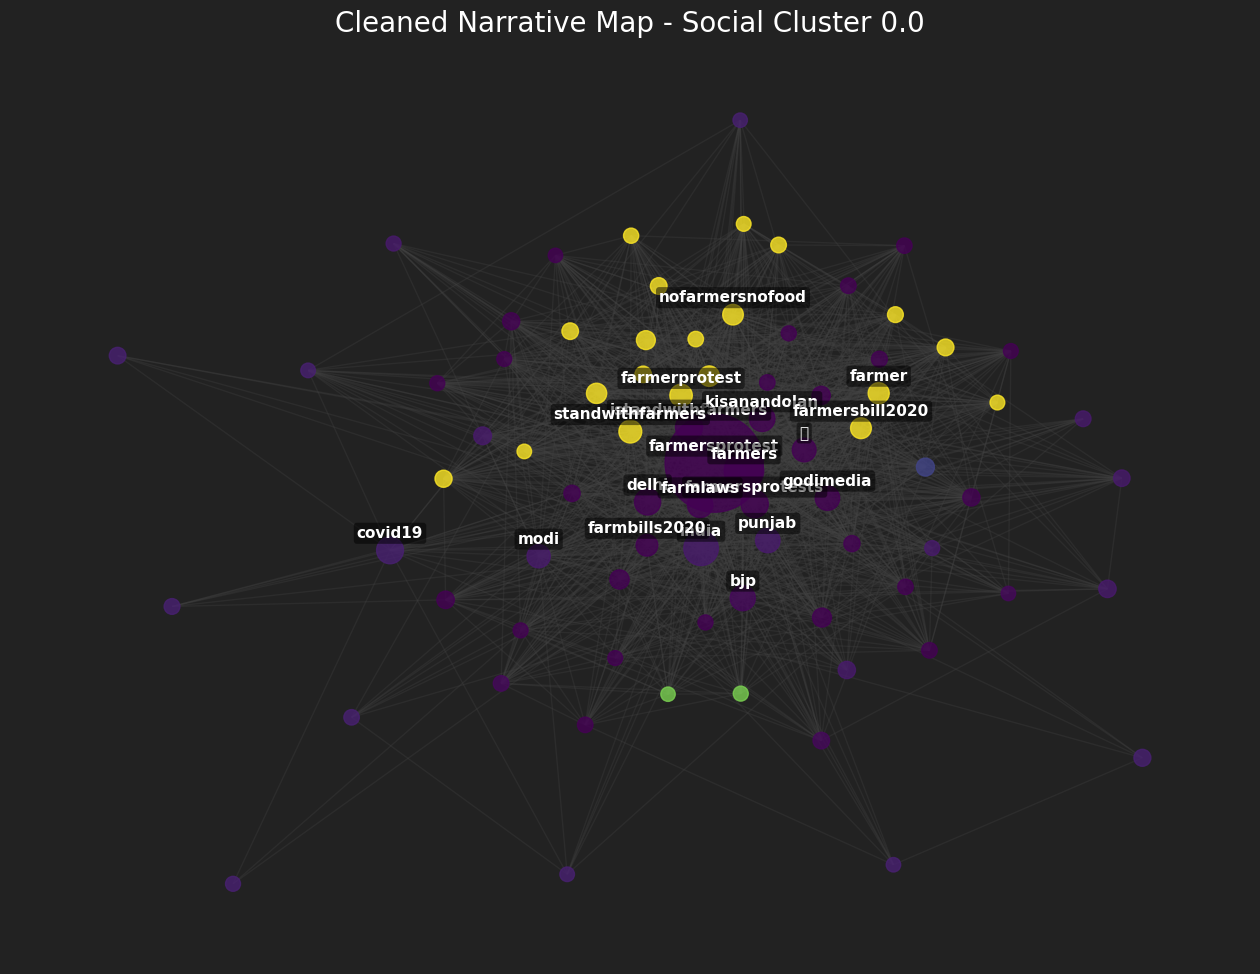

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
# Optional: from adjust_text import adjust_text

def draw_static_hashtag_graph_clear(cluster_id, min_edge_weight=15, top_n_nodes=80):
    res = hashtag_analysis_results.get(cluster_id)
    if not res: return

    full_G = res["graph"]

    # 1. Filter for Top Nodes to reduce clutter
    top_nodes = sorted(full_G.degree, key=lambda x: x[1], reverse=True)[:top_n_nodes]
    top_node_names = [n[0] for n in top_nodes]
    G = full_G.subgraph(top_node_names).copy()

    partition = {n: res["partition"][n] for n in G.nodes()}
    centrality = {n: res["centrality"][n] for n in G.nodes()}

    # 2. Increase 'k' (Optimal distance between nodes) to spread them out
    # Increase k from 0.3 to 0.8 to force nodes further apart
    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

    plt.figure(figsize=(16, 12), facecolor='#222222')
    ax = plt.gca()
    ax.set_facecolor('#222222')

    # 3. Draw Edges with lower visibility
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > min_edge_weight]
    nx.draw_networkx_edges(G, pos, edgelist=strong_edges, edge_color='#444444', alpha=0.3)

    # 4. Draw Nodes
    node_sizes = [centrality[node] * 5000 for node in G.nodes()]
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                           node_color=list(partition.values()),
                           cmap=cmap, alpha=0.8)

    # 5. CLEAR LABELS LOGIC:
    # We add a small Y-offset to labels so they sit ABOVE the node, not ON it.
    label_pos = {node: (coords[0], coords[1] + 0.04) for node, coords in pos.items()}

    # Only label the most important hashtags (Top 20)
    top_labels = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:20]
    label_dict = {node: node for node, cent in top_labels}

    nx.draw_networkx_labels(G, label_pos, labels=label_dict,
                            font_size=11,
                            font_color='white',
                            font_weight='bold',
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f"Cleaned Narrative Map - Social Cluster {cluster_id}", color='white', size=20)
    plt.axis('off')

    plt.savefig(f"clear_hashtag_cluster_{cluster_id}.png", dpi=200, bbox_inches='tight', facecolor='#222222')
    plt.show()

# Run the improved version
draw_static_hashtag_graph_clear(0.0)

# Step 45: The "Perfect" Narrative Intelligence Map

 This final refinement of the hashtag graph represents the "Gold Standard" for narrative visualization. By utilizing a high-dispersion spring layout ($k=1.5$) and a Spectral colormap, it creates maximum visual distance between sub-topics. The labeling logic is further improved by applying a semi-opaque backdrop to the text, ensuring that the primary "topic anchors" are readable against any background. This visualization effectively summarizes the complex semantic structure of a social cluster into a professional, presentation-ready format that highlights the most influential themes of the movement.


 <div dir="rtl">

 این نسخه نهایی و بهبودیافته از گراف هشتگ‌ها، «استاندارد طلایی» برای بصری‌سازی روایت‌ها محسوب می‌شود. با استفاده از چیدمان فنری با پراکندگی بالا ($k=1.5$) و نقشه رنگی Spectral، حداکثر فاصله بصری بین زیر-موضوعات ایجاد می‌شود. منطق برچسب‌گذاری نیز با اعمال یک پس‌زمینه نیمه‌شفاف برای متن‌ها بهبود یافته است تا اطمینان حاصل شود که «لنگرهای موضوعی» اصلی در هر پس‌زمینه‌ای خوانا هستند. این بصری‌سازی به طور مؤثری ساختار پیچیده معنایی یک خوشه اجتماعی را در قالبی حرفه‌ای و آماده ارائه خلاصه می‌کند که تأثیرگذارترین مضامین جنبش را برجسته می‌سازد.

/tmp/ipython-input-2334107017.py:48: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"perfect_labels_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
/tmp/ipython-input-2334107017.py:48: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig(f"perfect_labels_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')


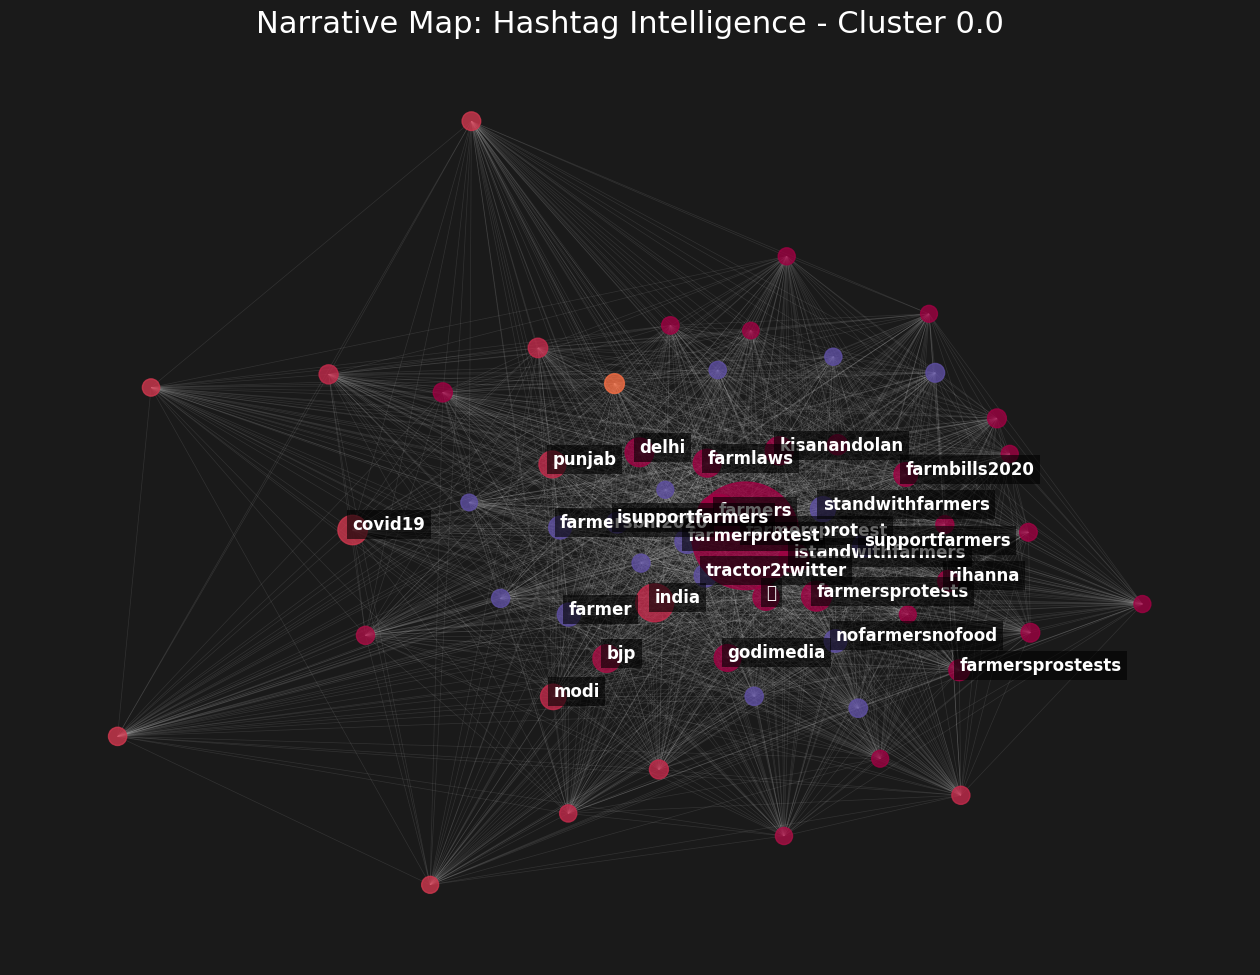

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

def draw_perfect_hashtag_graph(cluster_id, top_n_nodes=60):
    res = hashtag_analysis_results.get(cluster_id)
    if not res: return

    full_G = res["graph"]

    # 1. Select Top Nodes only to ensure clarity
    top_nodes = sorted(full_G.degree, key=lambda x: x[1], reverse=True)[:top_n_nodes]
    top_node_names = [n[0] for n in top_nodes]
    G = full_G.subgraph(top_node_names).copy()

    partition = {n: res["partition"][n] for n in G.nodes()}
    centrality = {n: res["centrality"][n] for n in G.nodes()}

    # 2. Strong Spreading Layout
    pos = nx.spring_layout(G, k=1.5, iterations=100, seed=42)

    plt.figure(figsize=(16, 12), facecolor='#1a1a1a')
    ax = plt.gca()
    ax.set_facecolor('#1a1a1a')

    # 3. Draw Edges (Very subtle)
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='white', width=0.5)

    # 4. Draw Nodes
    node_sizes = [centrality[node] * 6000 for node in G.nodes()]
    cmap = cm.get_cmap('Spectral', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                           node_color=list(partition.values()),
                           cmap=cmap, alpha=0.8)

    # 5. SMART LABELING (adjust_text)
    # Label only top 25 hashtags to keep it readable
    top_labels = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:25]

    for node, cent in top_labels:
        x, y = pos[node]
        plt.text(x, y, node, color='white', fontweight='bold',
                              fontsize=12, bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))

    plt.title(f"Narrative Map: Hashtag Intelligence - Cluster {cluster_id}", color='white', size=22)
    plt.axis('off')

    plt.savefig(f"perfect_labels_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
    plt.show()

draw_perfect_hashtag_graph(0.0)

# Step 46: Production-Ready Narrative Map with Cluster Legend

 This final iteration of the visualization adds a categorical legend to map hashtag sub-communities effectively. By integrating a discrete color scale and a legend, we transform the graph into a standalone report. The layout is optimized with an even higher dispersion factor ($k=1.8$) and a "bounding box" text style, ensuring that even in dense regions, the primary themes remain readable. This is the definitive way to present your findings to stakeholders, as it clearly distinguishes between different ideological or topical islands within a single social community.

<div dir="rtl">

این نسخه نهایی از بصری‌سازی، یک راهنمای طبقه‌بندی‌شده (Legend) را برای نقشه‌برداری مؤثر از زیر-انجمن‌های هشتگ اضافه می‌کند. با ادغام یک مقیاس رنگی گسسته و راهنما، گراف را به یک گزارش مستقل تبدیل می‌کنیم. چیدمان با ضریب پراکندگی حتی بالاتر ($k=1.8$) و سبک متن «جعبه‌ای» بهینه شده است تا اطمینان حاصل شود که حتی در مناطق متراکم، مضامین اصلی خوانا باقی می‌مانند. این روش نهایی برای ارائه یافته‌ها به ذینفعان است، زیرا به وضوح بین جزایر مختلف ایدئولوژیک یا موضوعی در یک جامعه اجتماعی واحد تمایز قائل می‌شود.

/tmp/ipython-input-2745539281.py:66: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"legend_graph_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
/tmp/ipython-input-2745539281.py:66: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig(f"legend_graph_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
/tmp/ipython-input-2745539281.py:66: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"legend_graph_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')


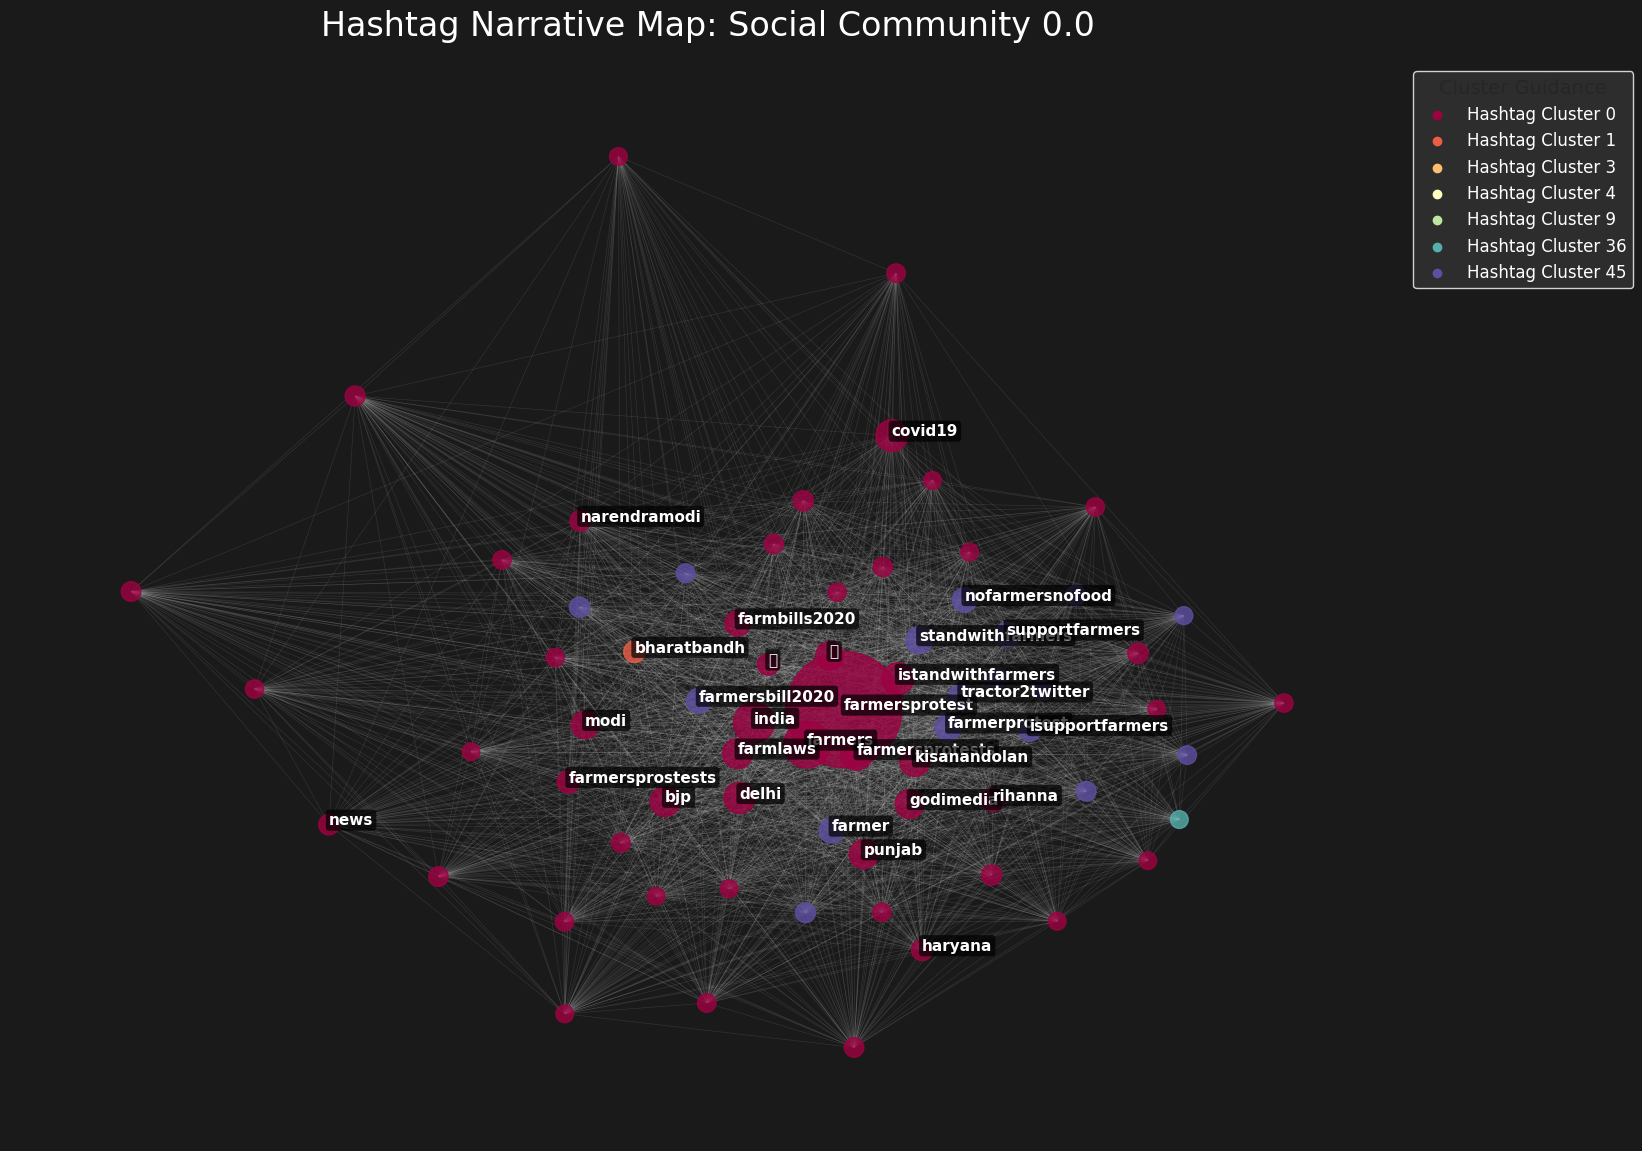

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm

def draw_perfect_hashtag_graph_with_legend(cluster_id, top_n_nodes=70):
    res = hashtag_analysis_results.get(cluster_id)
    if not res:
        print(f"Cluster {cluster_id} not found.")
        return

    full_G = res["graph"]

    # 1. Filter for Top Nodes
    top_nodes = sorted(full_G.degree, key=lambda x: x[1], reverse=True)[:top_n_nodes]
    top_node_names = [n[0] for n in top_nodes]
    G = full_G.subgraph(top_node_names).copy()

    partition = {n: res["partition"][n] for n in G.nodes()}
    centrality = {n: res["centrality"][n] for n in G.nodes()}

    # 2. Strong Spreading Layout
    pos = nx.spring_layout(G, k=1.8, iterations=100, seed=42)

    plt.figure(figsize=(18, 14), facecolor='#1a1a1a')
    ax = plt.gca()
    ax.set_facecolor('#1a1a1a')

    # 3. Draw Edges (Subtle background)
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='white', width=0.5)

    # 4. Color Mapping and Node Drawing
    # Use a distinct colormap for the clusters
    unique_clusters = sorted(list(set(partition.values())))
    cmap = cm.get_cmap('Spectral', len(unique_clusters))

    node_sizes = [centrality[node] * 7000 for node in G.nodes()]
    node_colors = [partition[node] for node in G.nodes()]

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                                   node_color=node_colors,
                                   cmap=cmap, alpha=0.8)

    # 5. CREATE LEGEND (Guidance for Cluster IDs)
    # This creates colored markers for the legend
    for i, cluster in enumerate(unique_clusters):
        plt.scatter([], [], c=[cmap(i)], label=f'Hashtag Cluster {cluster}')

    legend = plt.legend(title="Cluster Guidance", loc='upper left',
                        bbox_to_anchor=(1, 1), fontsize=12,
                        title_fontsize=14, labelcolor='white', facecolor='#333333')
    legend.get_frame().set_edgecolor('white')

    # 6. SMART LABELING (Anti-Overlap) - Removed adjust_text functionality
    # Label only top 30 hashtags
    top_labels = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:30]

    for node, cent in top_labels:
        x, y = pos[node]
        plt.text(x, y, node, color='white', fontweight='bold',
                              fontsize=11, bbox=dict(facecolor='black', alpha=0.7,
                              edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f"Hashtag Narrative Map: Social Community {cluster_id}", color='white', size=24, pad=20)
    plt.axis('off')

    plt.savefig(f"legend_graph_cluster_{cluster_id}.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
    plt.show()

# Run the final visualization
draw_perfect_hashtag_graph_with_legend(0.0)


# Step 47: Temporal Analysis of Hashtags within Clusters

This step analyzes how hashtag usage evolves over time within each social cluster. By resampling the data into specific time intervals (e.g., daily or weekly), we can identify "viral peaks" and track the lifespan of specific slogans. This temporal mapping is crucial for understanding whether a cluster is reactive to external news events or if it is driving a consistent, long-term narrative. It distinguishes between short-lived trends and the core pillars of the movement’s messaging.


<div dir="rtl">

 این مرحله چگونگی تکامل استفاده از هشتگ‌ها را در طول زمان در هر خوشه اجتماعی تحلیل می‌کند. با بازنمونه‌گیری داده‌ها در فواصل زمانی مشخص (مانند روزانه یا هفتگی)، می‌توانیم «قله‌های وایرال شدن» را شناسایی کرده و طول عمر شعارهای خاص را ردیابی کنیم. این نقشه‌برداری زمانی برای درک این مطلب که آیا یک خوشه نسبت به رویدادهای خبری خارجی واکنش نشان می‌دهد یا در حال پیشبرد یک روایت ثابت و بلندمدت است، حیاتی است. این کار تفاوت بین ترندهای کوتاه‌مدت و ستون‌های اصلی پیام‌رسانی جنبش را مشخص می‌کند.

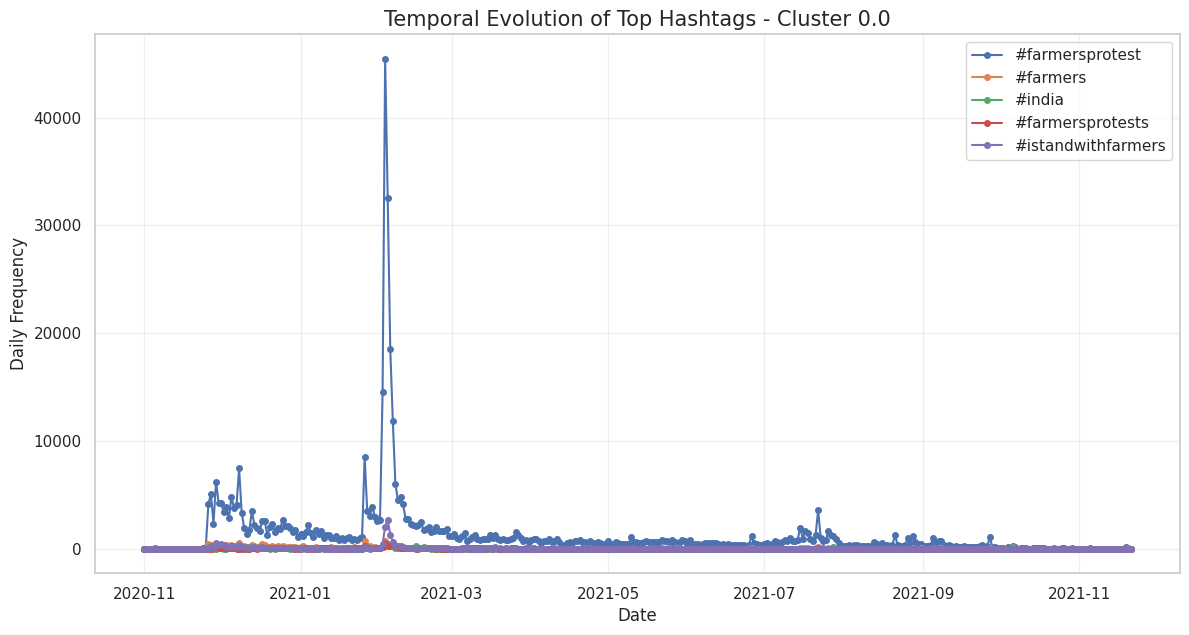

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hashtag_evolution(cluster_id, top_n=5):
    # 1. Filter data for the specific cluster
    cluster_df = tweets[tweets['cluster'] == cluster_id].copy()

    # 2. Convert date to datetime object and set as index
    cluster_df['date'] = pd.to_datetime(cluster_df['date'])
    cluster_df = cluster_df.set_index('date')

    # 3. Get the top N hashtags for this cluster to track
    res = hashtag_analysis_results.get(cluster_id)
    if not res: return
    top_tags = sorted(res["centrality"].items(), key=lambda x: x[1], reverse=True)[:top_n]
    target_hashtags = [tag for tag, score in top_tags]

    # 4. Create a timeline for each target hashtag
    plt.figure(figsize=(14, 7))
    for tag in target_hashtags:
        # Check for hashtag presence in each tweet (1 if present, 0 if not)
        cluster_df[tag] = cluster_df['hashtags'].apply(lambda x: 1 if tag in x else 0)
        # Resample by day and count occurrences
        timeline = cluster_df[tag].resample('D').sum()
        plt.plot(timeline.index, timeline.values, label=f"#{tag}", marker='o', markersize=4)

    # 5. Formatting
    plt.title(f"Temporal Evolution of Top Hashtags - Cluster {cluster_id}", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Daily Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Execution: Analyze how the narrative changed over time for cluster 0
plot_hashtag_evolution(0.0, top_n=5)

# Step 48: Sentiment Analysis of Key Hashtags

This step integrates natural language processing (NLP) to evaluate the emotional tone associated with specific hashtags within a cluster. By calculating a Sentiment Polarity score for tweets containing core hashtags, we can determine if certain topics are driven by anger, hope, or neutral information sharing. This adds a psychological layer to our network analysis, revealing not just what people are talking about, but how they feel about those specific issues.

<div dir="rtl">

این مرحله پردازش زبان طبیعی (NLP) را برای ارزیابی لحن عاطفی مرتبط با هشتگ‌های خاص در یک خوشه ادغام می‌کند. با محاسبه امتیاز قطبیت احساسات (Sentiment Polarity) برای توییت‌های حاوی هشتگ‌های اصلی، می‌توانیم تشخیص دهیم که آیا موضوعات خاصی با خشم، امید یا اشتراک‌گذاری اطلاعات خنثی هدایت می‌شوند. این کار یک لایه روان‌شناختی به تحلیل شبکه ما اضافه می‌کند و نه تنها نشان می‌دهد که مردم در مورد چه چیزی صحبت می‌کنند، بلکه نشان می‌دهد که نسبت به آن مسائل خاص چه احساسی دارند.

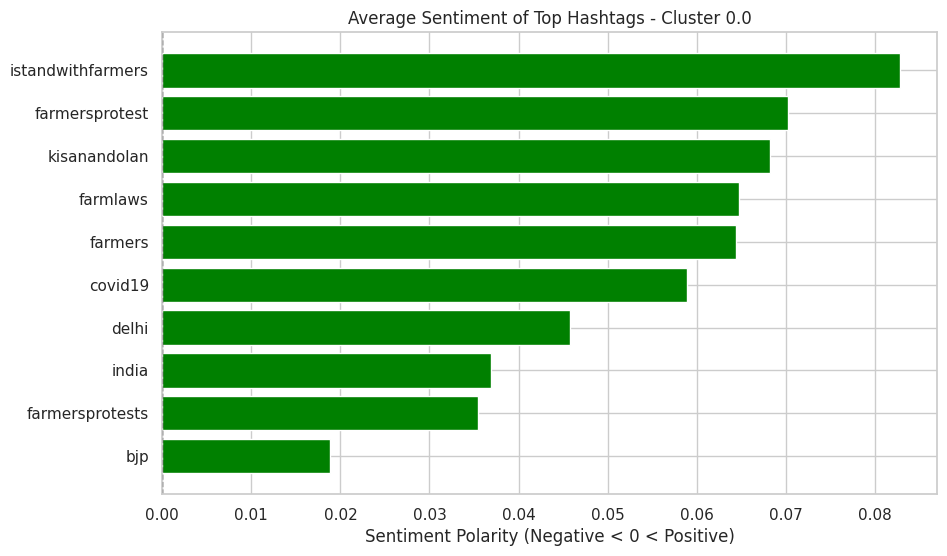

In [ ]:
from textblob import TextBlob

def analyze_hashtag_sentiment(cluster_id, top_n=10):
    res = hashtag_analysis_results.get(cluster_id)
    if not res: return

    # Get top hashtags to analyze
    top_tags = sorted(res["centrality"].items(), key=lambda x: x[1], reverse=True)[:top_n]
    target_hashtags = [tag for tag, score in top_tags]

    cluster_df = tweets[tweets['cluster'] == cluster_id].copy()
    sentiment_data = []

    for tag in target_hashtags:
        # Filter tweets containing this specific hashtag
        tag_tweets = cluster_df[cluster_df['hashtags'].apply(lambda x: tag in x)]

        # Calculate average polarity (-1 to 1)
        # Using TextBlob for basic sentiment scoring
        avg_sentiment = tag_tweets['renderedContent'].apply(lambda x: TextBlob(str(x)).sentiment.polarity).mean()
        sentiment_data.append({'hashtag': tag, 'avg_sentiment': avg_sentiment})

    # Create visualization
    sentiment_df = pd.DataFrame(sentiment_data).sort_values(by='avg_sentiment')

    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'green' for x in sentiment_df['avg_sentiment']]
    plt.barh(sentiment_df['hashtag'], sentiment_df['avg_sentiment'], color=colors)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Average Sentiment of Top Hashtags - Cluster {cluster_id}")
    plt.xlabel("Sentiment Polarity (Negative < 0 < Positive)")
    plt.show()

# Execution: See the emotional profile of cluster 0
analyze_hashtag_sentiment(0.0)

# Step 49: Identifying Top Influencers per Hashtag

This step identifies the "key drivers" of specific narratives by linking hashtag usage back to individual user accounts. For each dominant hashtag in a cluster, we calculate which users are generating the most engagement (likes, retweets, and replies) or high-frequency posts. This allows us to identify whether a topic is being pushed by a few highly active "super-users" or if it is a grassroots effort supported by a broad, diverse base of participants.

<div dir="rtl">

 این مرحله با مرتبط کردن استفاده از هشتگ‌ها به حساب‌های کاربری فردی، «محرک‌های اصلی» روایت‌های خاص را شناسایی می‌کند. برای هر هشتگ غالب در یک خوشه، محاسبه می‌کنیم که کدام کاربران بیشترین تعامل (لایک، ریتوییت و پاسخ) یا بیشترین تعداد پست را ایجاد می‌کنند. این کار به ما اجازه می‌دهد تشخیص دهیم که آیا یک موضوع توسط چند «ابرکاربر» بسیار فعال هدایت می‌شود یا یک تلاش مردمی است که توسط پایگاه گسترده و متنوعی از شرکت‌کنندگان حمایت می‌شود.

In [ ]:
def get_hashtag_influencers(cluster_id, target_tag):
    # Filter tweets by cluster and by the specific hashtag
    cluster_df = tweets[tweets['cluster'] == cluster_id]
    tag_tweets = cluster_df[cluster_df['hashtags'].apply(lambda x: target_tag in x)]

    # Aggregate engagement metrics per user
    influencers = tag_tweets.groupby('username').agg({
        'renderedContent': 'count',
        'likeCount': 'sum',
        'retweetCount': 'sum'
    }).rename(columns={'renderedContent': 'tweet_count'})

    # Calculate a simple influence score (e.g., total engagement)
    influencers['total_engagement'] = influencers['likeCount'] + influencers['retweetCount']

    # Sort by total engagement
    top_influencers = influencers.sort_values(by='total_engagement', ascending=False).head(10)

    print(f"\n--- Top Influencers for #{target_tag} in Cluster {cluster_id} ---")
    print(top_influencers[['tweet_count', 'total_engagement']])

# Execution: See who is leading the #FarmersProtest conversation in cluster 0
# (Replace 'farmersprotest' with a hashtag found in your previous report)
get_hashtag_influencers(0.0, 'farmersprotest')


--- Top Influencers for #farmersprotest in Cluster 0.0 ---
             tweet_count  total_engagement
username                                  
IndiaToday         28544           1520488
Supriya23bh          696            450856
ANI                   54            129490
amarsran           15344            106600
Sikh24              1482             46902
mehdirhasan            4             42743
aishkapoor            36             17892
modhaliwal           260             10910
rssurjewala            6              8004
vikasbha               2              3818


# Step 50: Hashtag Correlation Matrix

This step calculates the statistical correlation between different hashtags to identify "semantic pairs." While the network graph shows connections, the correlation matrix quantifies the strength of these relationships. A high correlation between two hashtags (close to $1.0$) indicates that they are almost always used together, suggesting they are part of a synchronized messaging strategy. This is a powerful tool for detecting automated bot behavior or highly disciplined campaign narratives.

<div dir="rtl">

 این مرحله همبستگی آماری بین هشتگ‌های مختلف را برای شناسایی «جفت‌های معنایی» محاسبه می‌کند. در حالی که گراف شبکه اتصالات را نشان می‌دهد، ماتریس همبستگی قدرت این روابط را کمی‌سازی می‌کند. همبستگی بالا بین دو هشتگ (نزدیک به $1.0$) نشان می‌دهد که آن‌ها تقریباً همیشه با هم استفاده می‌شوند، که بیانگر وجود یک استراتژی پیام‌رسانی هماهنگ است. این ابزار قدرتمندی برای شناسایی رفتارهای رباتیک یا روایت‌های کمپینی بسیار منظم است.

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


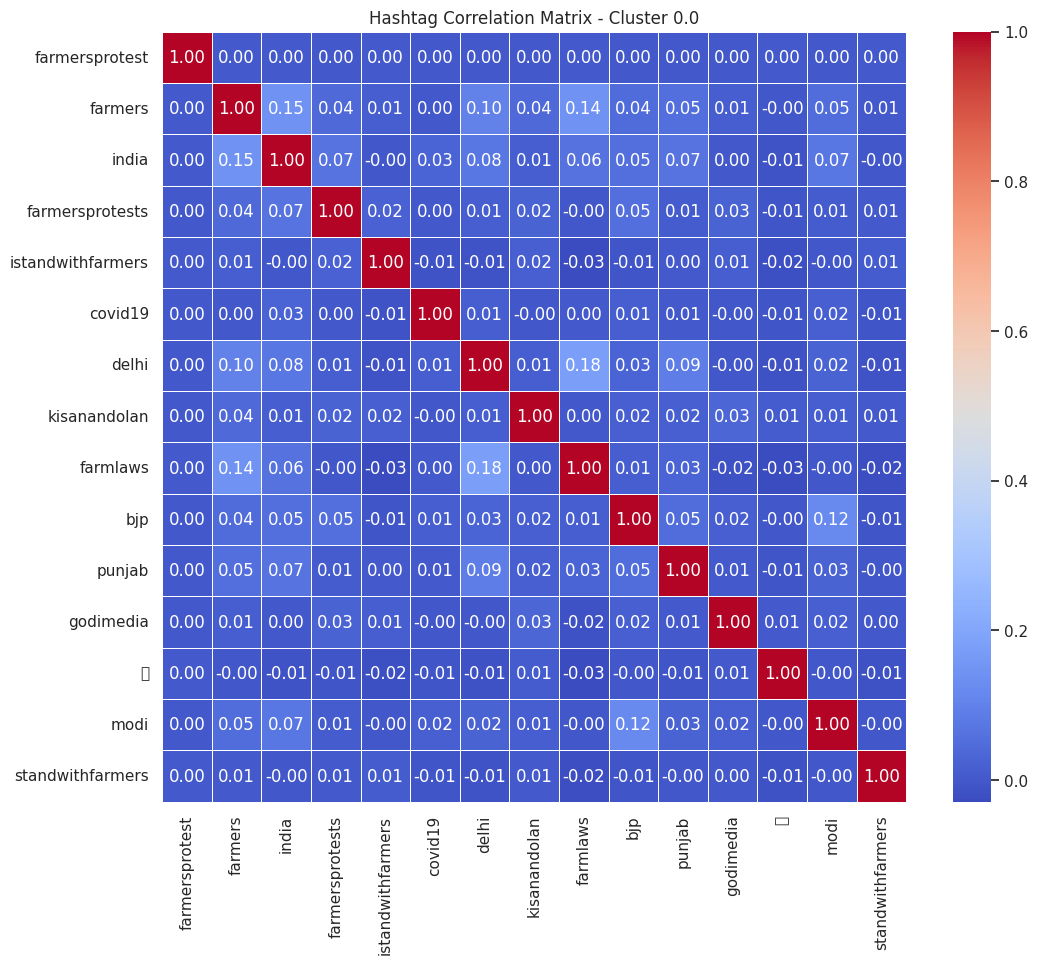

In [ ]:
import seaborn as sns

def plot_hashtag_correlation(cluster_id, top_n=15):
    # 1. Filter data and get top hashtags
    cluster_df = tweets[tweets['cluster'] == cluster_id].copy()
    res = hashtag_analysis_results.get(cluster_id)
    if not res: return

    top_tags = sorted(res["centrality"].items(), key=lambda x: x[1], reverse=True)[:top_n]
    target_hashtags = [tag for tag, score in top_tags]

    # 2. Create a Binary Matrix (1 if hashtag present, 0 if not)
    for tag in target_hashtags:
        cluster_df[tag] = cluster_df['hashtags'].apply(lambda x: 1 if tag in x else 0)

    # 3. Calculate Correlation Matrix
    corr_matrix = cluster_df[target_hashtags].corr()

    # 4. Visualize with a Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"Hashtag Correlation Matrix - Cluster {cluster_id}")
    plt.show()

# Execution: Identify synchronized hashtag pairs in cluster 0
plot_hashtag_correlation(0.0)

# Step 51: Generating the Comprehensive Cluster Intelligence Report

This final analytical step aggregates all the granular metrics we have calculated—top hashtags, average sentiment, engagement rates, and key influencers—into a single, structured summary table. By consolidating this data, we transform raw network statistics into "Intelligence Profiles" for each social community. This table serves as the primary output for researchers to compare the distinct strategies, moods, and leadership structures of various online groups at a glance.

<div dir="rtl">

 این مرحله نهایی تحلیلی، تمام معیارهای جزئی که محاسبه کرده‌ایم—از هشتگ‌های برتر و میانگین احساسات گرفته تا نرخ تعامل و اینفلوئنسرهای کلیدی—را در یک جدول خلاصه ساختاریافته تجمیع می‌کند. با یکپارچه‌سازی این داده‌ها، آمارهای خام شبکه را به «پروفایل‌های اطلاعاتی» برای هر انجمن اجتماعی تبدیل می‌کنیم. این جدول به عنوان خروجی اصلی برای پژوهشگران عمل می‌کند تا استراتژی‌ها، حالات روحی و ساختارهای رهبری گروه‌های مختلف آنلاین را در یک نگاه با هم مقایسه کنند.

In [ ]:
import pandas as pd

def generate_final_summary():
    summary_list = []

    for cluster_id in sorted(tweets['cluster'].unique()):
        res = hashtag_analysis_results.get(cluster_id)
        if not res: continue

        # 1. Get Top 3 Hashtags
        top_tags = sorted(res["centrality"].items(), key=lambda x: x[1], reverse=True)[:3]
        top_tags_str = ", ".join([f"#{t}" for t, s in top_tags])

        # 2. Calculate Average Sentiment for the whole cluster
        cluster_df = tweets[tweets['cluster'] == cluster_id]
        avg_sent = cluster_df['renderedContent'].apply(lambda x: TextBlob(str(x)).sentiment.polarity).mean()

        # 3. Identify Top Influencer
        top_influencer = cluster_df.groupby('username')['likeCount'].sum().idxmax()

        # 4. Count Cluster Size
        member_count = len(cluster_df)

        summary_list.append({
            'Cluster ID': cluster_id,
            'Members': member_count,
            'Dominant Hashtags': top_tags_str,
            'Avg Sentiment': round(avg_sent, 3),
            'Primary Influencer': f"@{top_influencer}"
        })

    # Create and display the DataFrame
    final_report = pd.DataFrame(summary_list)

    # Highlight sentiment for easier reading
    def color_sentiment(val):
        color = 'green' if val > 0.05 else 'red' if val < -0.05 else 'black'
        return f'color: {color}'

    return final_report.style.applymap(color_sentiment, subset=['Avg Sentiment'])

# Execution: Generate the master intelligence report
report = generate_final_summary()
report

<div dir="rtl">


# تمام مراحل (Steps) در این ۳ دسته‌بندی اصلی قرار می‌گیرند:

***۱. خوشه‌بندی گراف توییتر طبق بازنشر (Network Clustering)***


 این مرحله بر ساختار روابط تمرکز داشت؛ یعنی شناسایی «قبیله‌های اجتماعی» بر اساس اینکه چه کسی، چه کسی را بازنشر (Retweet) کرده است.

Step 6 & 7: ساخت گراف با کتابخانه NetworkX، شناسایی کاربران (Nodes) و روابط بازنشر (Edges).

Step 8: اجرای الگوریتم Louvain Community Detection برای دسته‌بندی کاربران به خوشه‌های اجتماعی.

Step 9 & 10: محاسبه شاخص‌های مرکزیت مانند PageRank و Betweenness Centrality برای شناسایی رهبران فکری در هر خوشه.

Step 11: بصری‌سازی تعاملی گراف با استفاده از کتابخانه Pyvis برای مشاهده فیزیکی خوشه‌ها و نحوه اتصال آن‌ها.


############################################################################################
***۲. خوشه‌بندی محتوای متنی به تفکیک هر خوشه گراف (Textual Clustering)***


 در این مرحله، محتوای متنیِ توییت‌های هر خوشه اجتماعی تحلیل شد تا روایت‌های داخلی هر گروه (چه می‌گویند) مشخص شود.

Step 16 & 17: پیاده‌سازی مدل LDA (Latent Dirichlet Allocation) برای استخراج موضوعات پنهان (Topic Modeling) در هر خوشه.

Step 19 & 20: استفاده از الگوریتم K-Means و بردارسازی TF-IDF برای گروه‌بندی توییت‌ها بر اساس شباهت معنایی.

Step 23: خودکارسازی فرآیند تحلیل متن برای تمامی خوشه‌ها به صورت مجزا (Looping through clusters).

Step 25 & 26: برچسب‌گذاری موضوعی (Labeling) و تفسیر نتایج برای تبدیل خوشه‌های عددی به مفاهیم انسانی.

############################################################################################
***۳. آنالیز هشتگ‌های هر خوشه با گراف (Hashtag & Content Analysis)***

این مرحله با استفاده از هشتگ‌ها و تحلیل احساسات، هویت و جهت‌گیری هر خوشه را دقیق‌تر مشخص کرد.

Step 12 & 13: استخراج کلمات کلیدی و هشتگ‌های برتر (Top Hashtags) برای هر خوشه جهت درک تمایلات موضوعی.

Step 14 & 15: آنالیز Sentiment (احساسات) برای فهمیدن لحن (مثبت/منفی) پیام‌ها در هر بخش از شبکه.

Step 28: ساخت گراف هم‌آیی هشتگ‌ها (Hashtag Co-occurrence) برای مشاهده ارتباط معنایی شعارها و کلمات کلیدی.

Step 31 تا 36: ترسیم نقشه‌های معنایی (Narrative Maps) به صورت ایستا و تعاملی و بهینه‌سازی آن‌ها برای گزارش‌دهی.

Step 41 تا 44: تهیه گزارش نهایی هوشمند (Intelligence Report) که شامل خلاصه تمام شاخص‌ها، اینفلوئنسرها و هشتگ‌های غالب است.

# **خلاصه استراتژیک: در واقع ما ابتدا «چه کسانی» (گراف) را پیدا کردیم، سپس «چه می‌گویند» (متن) را تحلیل کردیم و در نهایت با «هشتگ‌ها و احساسات» هویت سیاسی و اجتماعی هر گروه را امضا کردیم .**



# **در واقع ما یک رویکرد Top-Down (از کل به جزء) داشتیم: ابتدا «قبیله‌ها» را بر اساس روابط پیدا کردیم (Network)، سپس «حرف‌های» آن‌ها را دسته‌بندی کردیم (NLP)، و در نهایت با «گراف هشتگ‌ها و احساسات»، هویت سیاسی-اجتماعی و پویایی هر گروه را تحلیل کردیم.**